#### Benchmaking Experiment 001
- Model : Model1
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [9]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "video-V1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 20,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model1(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, attr_size, add_prepL=True, max_len=1024, dropout=0.1):
        super(Model1, self).__init__()
        self.add_prepL = add_prepL
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.attr_size = attr_size

        # feature prep layer
        if self.add_prepL:
            self.DenseL = nn.Linear(in_ft, d_model)
        else:
            self.d_model = self.in_ft 
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)

        # positional encoding concat <-> LSTM 
        self.lstmL = nn.LSTM(input_size=d_model, hidden_size=ft_size, batch_first=True)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))

    def forward(self, x):
        if self.add_prepL:
            x = self.DenseL(x)

        out = self.AttnL(x)
        lstm_out, hidden = self.lstmL(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(lstm_out[:, -1, :])
        ft_out = self.DecDenseL(attr_out)
        return attr_out, ft_out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [10]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 31/31 [00:00<00:00, 69.98batch/s, loss=2.64]


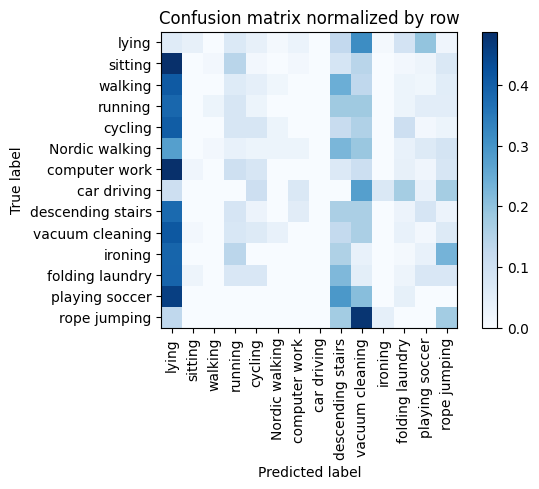

Training Epoch:   5%|▌         | 1/20 [00:05<01:52,  5.90s/it]

Overall accuracy: 0.041



eval: 100%|██████████| 31/31 [00:00<00:00, 51.15batch/s, loss=2.58]


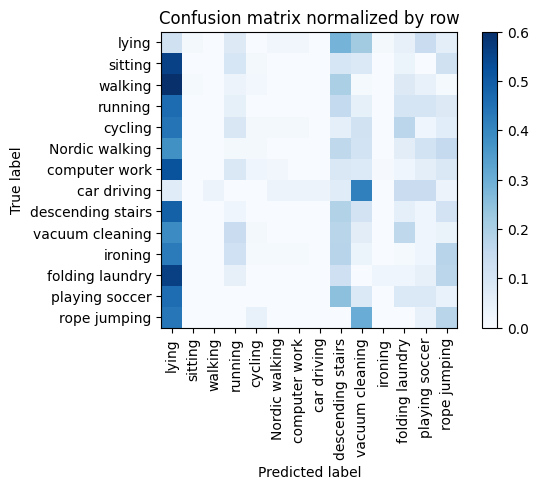

Training Epoch:  10%|█         | 2/20 [00:09<01:22,  4.61s/it]

Overall accuracy: 0.035



eval: 100%|██████████| 31/31 [00:00<00:00, 74.52batch/s, loss=3.14]


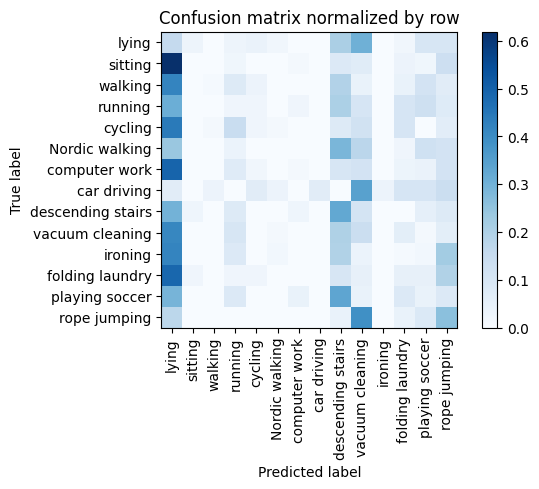

Training Epoch:  15%|█▌        | 3/20 [00:13<01:09,  4.08s/it]

Overall accuracy: 0.057



eval: 100%|██████████| 31/31 [00:00<00:00, 59.90batch/s, loss=2.87]


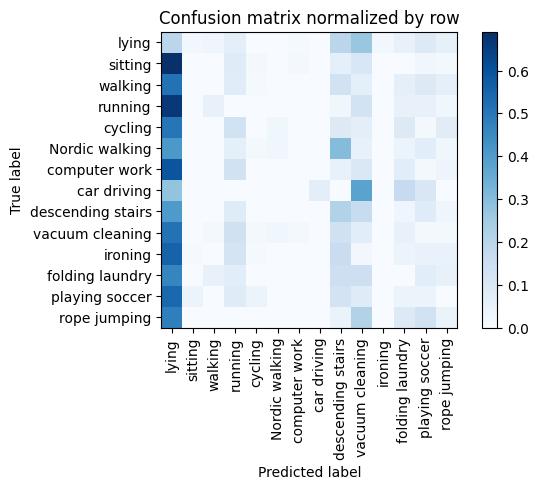

Training Epoch:  20%|██        | 4/20 [00:16<01:03,  3.95s/it]

Overall accuracy: 0.040



eval: 100%|██████████| 31/31 [00:00<00:00, 69.81batch/s, loss=2.41]


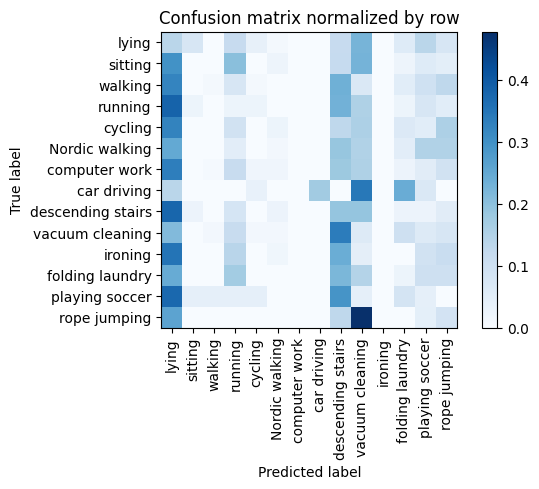

Training Epoch:  25%|██▌       | 5/20 [00:20<00:59,  3.94s/it]

Overall accuracy: 0.038



eval: 100%|██████████| 31/31 [00:00<00:00, 70.44batch/s, loss=2.79]


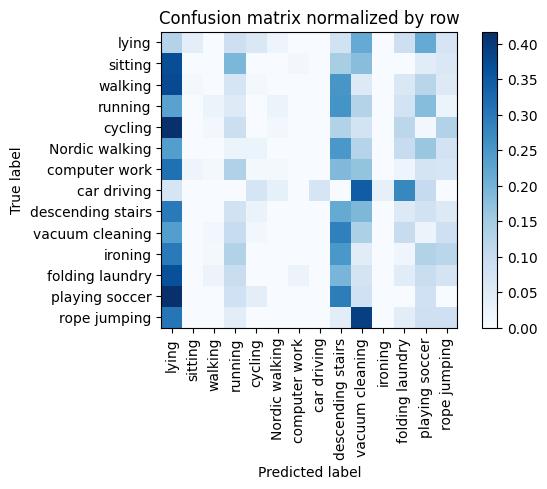

Training Epoch:  30%|███       | 6/20 [00:24<00:55,  3.98s/it]

Overall accuracy: 0.042



eval: 100%|██████████| 31/31 [00:00<00:00, 61.44batch/s, loss=3.27]


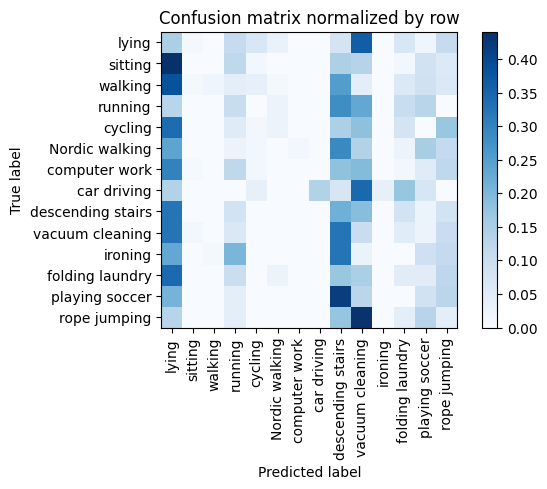

Training Epoch:  35%|███▌      | 7/20 [00:28<00:50,  3.85s/it]

Overall accuracy: 0.048



eval: 100%|██████████| 31/31 [00:00<00:00, 63.72batch/s, loss=2.99]


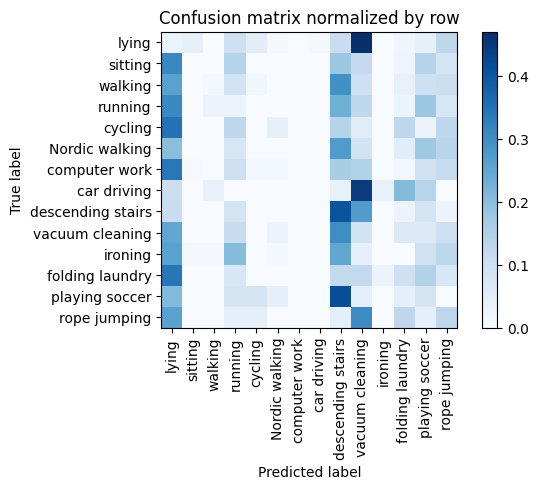

Training Epoch:  40%|████      | 8/20 [00:31<00:45,  3.77s/it]

Overall accuracy: 0.036



eval: 100%|██████████| 31/31 [00:00<00:00, 60.72batch/s, loss=2.96]


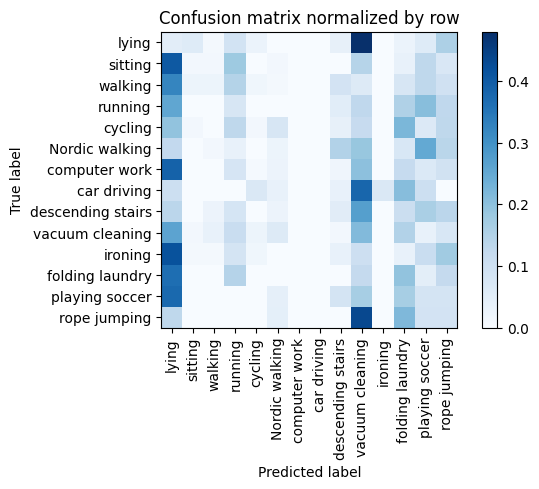

Training Epoch:  45%|████▌     | 9/20 [00:35<00:41,  3.77s/it]

Overall accuracy: 0.047



eval: 100%|██████████| 31/31 [00:00<00:00, 67.24batch/s, loss=3.52]


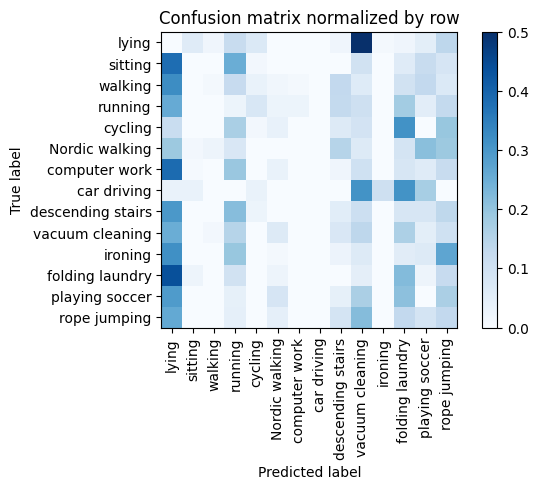

Training Epoch:  50%|█████     | 10/20 [00:39<00:37,  3.70s/it]

Overall accuracy: 0.028



eval: 100%|██████████| 31/31 [00:00<00:00, 72.59batch/s, loss=2.72]


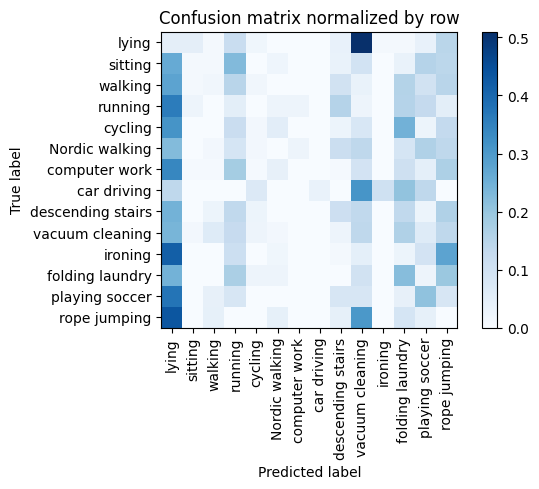

Training Epoch:  55%|█████▌    | 11/20 [00:42<00:32,  3.66s/it]

Overall accuracy: 0.041



eval: 100%|██████████| 31/31 [00:00<00:00, 69.98batch/s, loss=3.29]


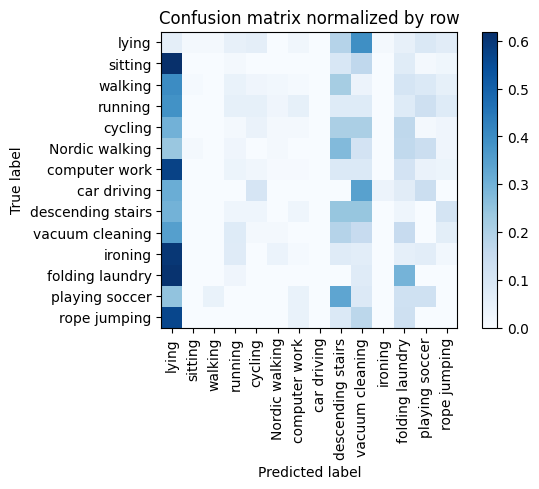

Training Epoch:  60%|██████    | 12/20 [00:46<00:29,  3.67s/it]

Overall accuracy: 0.050



eval: 100%|██████████| 31/31 [00:00<00:00, 62.74batch/s, loss=3.02]


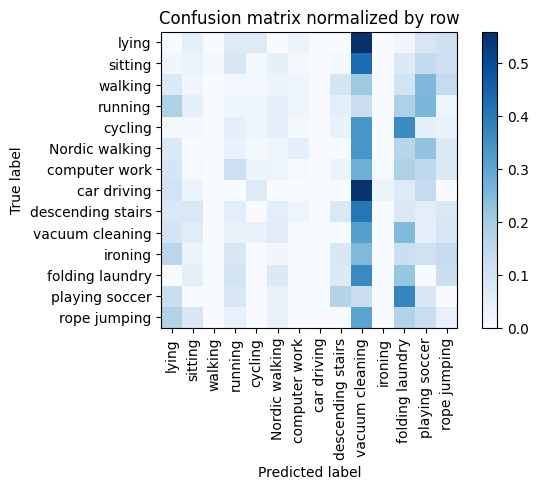

Training Epoch:  65%|██████▌   | 13/20 [00:50<00:25,  3.69s/it]

Overall accuracy: 0.050



eval: 100%|██████████| 31/31 [00:00<00:00, 59.03batch/s, loss=3.14]


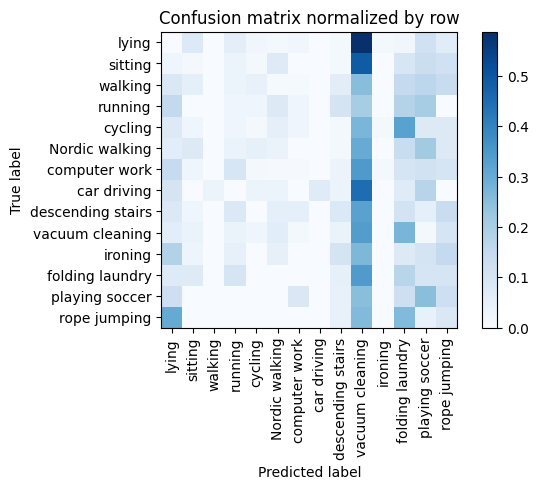

Training Epoch:  70%|███████   | 14/20 [00:54<00:22,  3.82s/it]

Overall accuracy: 0.055



eval: 100%|██████████| 31/31 [00:00<00:00, 60.84batch/s, loss=2.64]


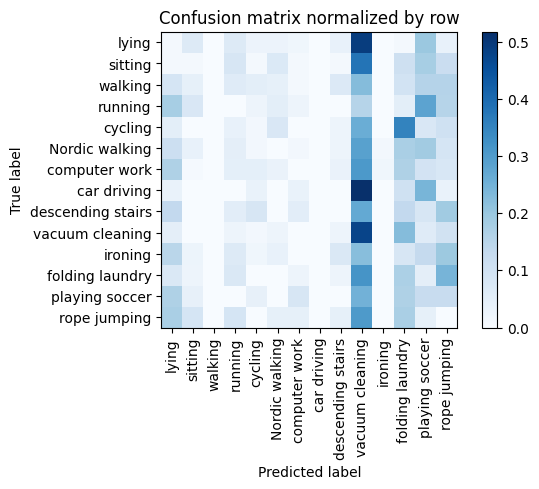

Training Epoch:  75%|███████▌  | 15/20 [00:58<00:19,  3.94s/it]

Overall accuracy: 0.052



eval: 100%|██████████| 31/31 [00:00<00:00, 56.41batch/s, loss=2.79]


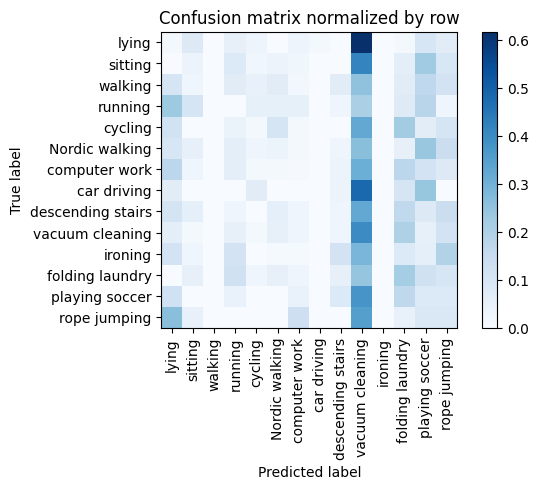

Training Epoch:  80%|████████  | 16/20 [01:03<00:16,  4.07s/it]

Overall accuracy: 0.056



eval: 100%|██████████| 31/31 [00:00<00:00, 66.81batch/s, loss=2.96]


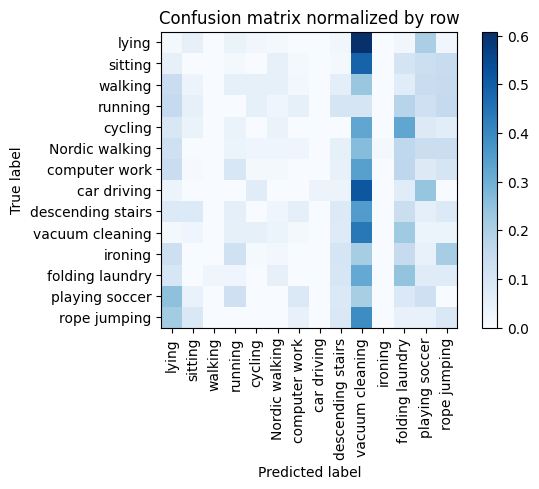

Training Epoch:  85%|████████▌ | 17/20 [01:06<00:12,  4.02s/it]

Overall accuracy: 0.058



eval: 100%|██████████| 31/31 [00:00<00:00, 66.17batch/s, loss=3.02]


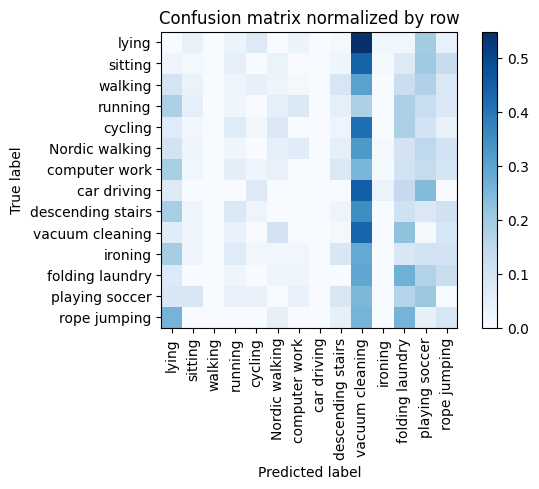

Training Epoch:  90%|█████████ | 18/20 [01:10<00:07,  3.93s/it]

Overall accuracy: 0.062



eval: 100%|██████████| 31/31 [00:00<00:00, 71.82batch/s, loss=3.12]


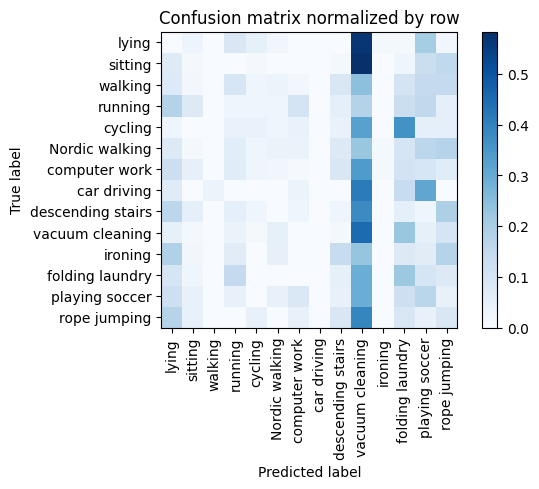

Training Epoch:  95%|█████████▌| 19/20 [01:14<00:03,  3.87s/it]

Overall accuracy: 0.062



eval: 100%|██████████| 31/31 [00:00<00:00, 71.07batch/s, loss=3.25]


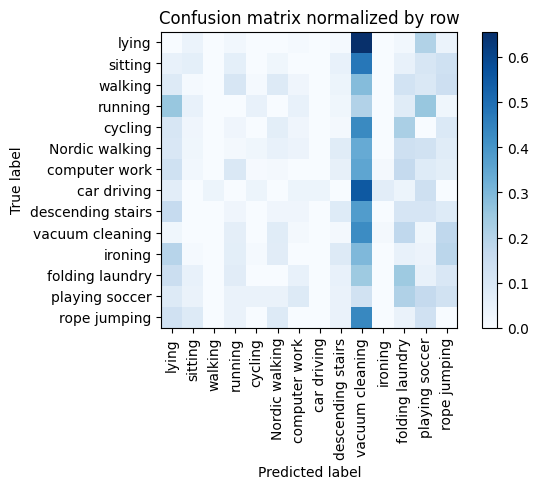

Overall accuracy: 0.062



eval: 100%|██████████| 34/34 [00:00<00:00, 97.01batch/s, loss=1.88] 


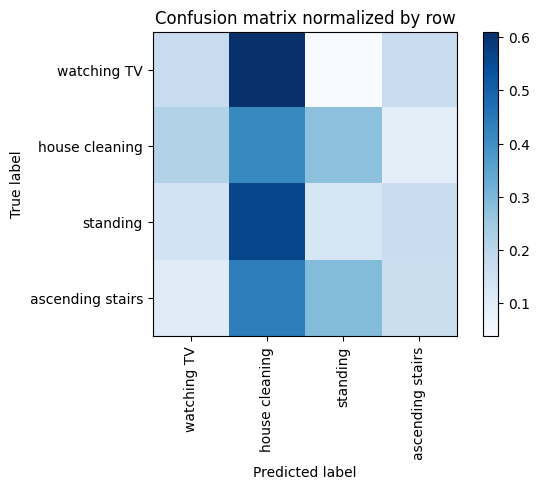

Overall accuracy: 0.239

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.281      0.413      0.335      0.338        358|	 standing: 0.277,	watching TV: 0.215,	
        standing       0.224      0.130      0.164      0.335        355|	 house cleaning: 0.561,	ascending stairs: 0.169,	watching TV: 0.141,	
ascending stairs       0.203      0.166      0.182      0.177        187|	 house cleaning: 0.439,	standing: 0.289,	
     watching TV       0.160      0.176      0.168      0.150        159|	 house cleaning: 0.610,	ascending stairs: 0.176,	

----------------------------------------------------------------------------------------------------
     avg / total       0.230      0.239      0.226        1.0       1059|	      

{'total_accuracy': 0.23890462700661, 'precision': 0.2170933610700455, 'recall': 0.22121532900452973, 'f1': 0.21228623877003586}
================ Fold-1 ================
Unseen Classes : ['walking', 'rop

eval: 100%|██████████| 31/31 [00:00<00:00, 69.02batch/s, loss=3.27]


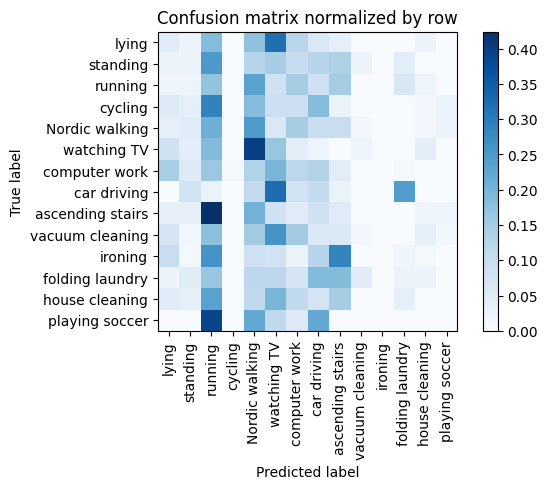

Training Epoch:   5%|▌         | 1/20 [00:03<01:11,  3.78s/it]

Overall accuracy: 0.068



eval: 100%|██████████| 31/31 [00:00<00:00, 69.81batch/s, loss=2.95]


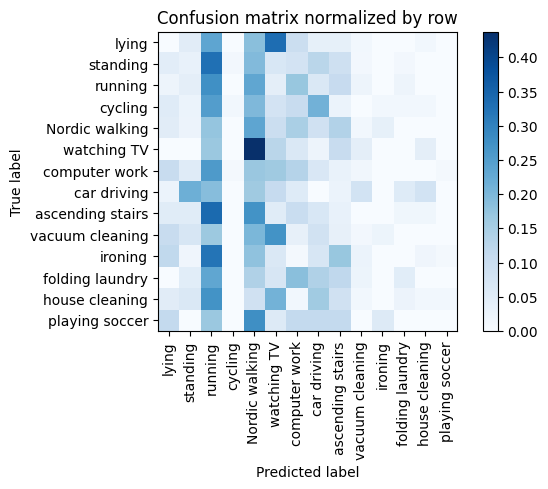

Training Epoch:  10%|█         | 2/20 [00:07<01:07,  3.77s/it]

Overall accuracy: 0.067



eval: 100%|██████████| 31/31 [00:00<00:00, 66.37batch/s, loss=2.69]


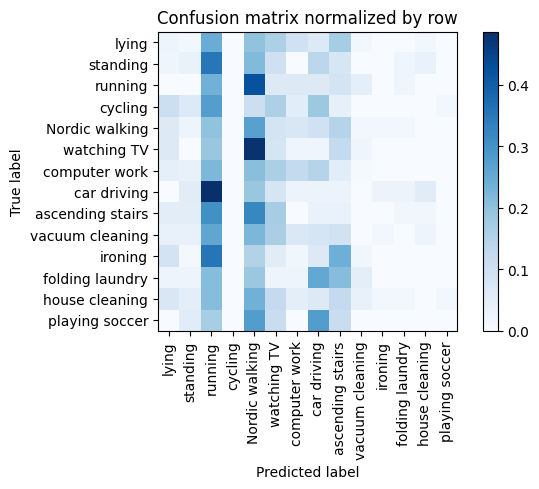

Training Epoch:  15%|█▌        | 3/20 [00:11<01:03,  3.72s/it]

Overall accuracy: 0.062



eval: 100%|██████████| 31/31 [00:00<00:00, 59.95batch/s, loss=2.94]


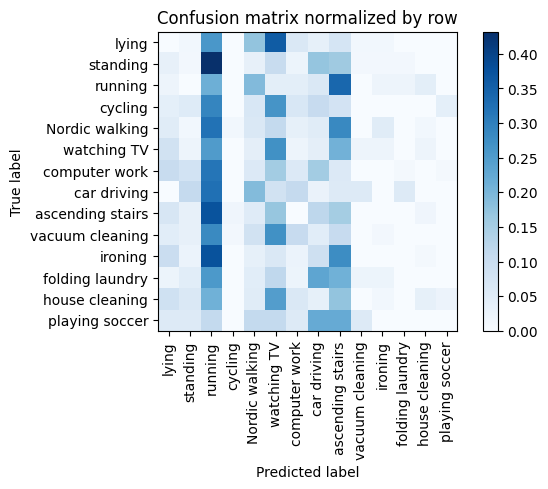

Training Epoch:  20%|██        | 4/20 [00:15<01:00,  3.78s/it]

Overall accuracy: 0.050



eval: 100%|██████████| 31/31 [00:00<00:00, 53.77batch/s, loss=2.62]


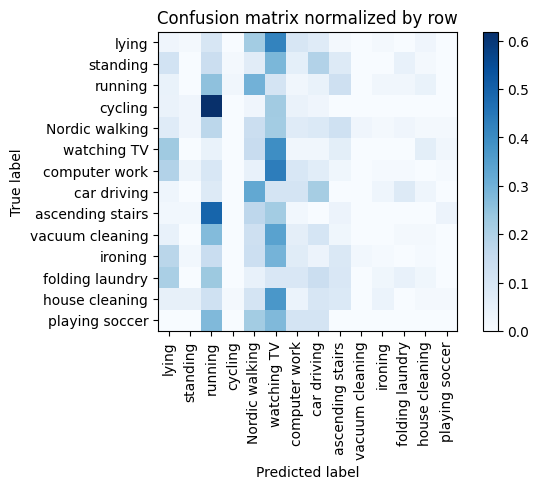

Training Epoch:  25%|██▌       | 5/20 [00:18<00:56,  3.79s/it]

Overall accuracy: 0.072



eval: 100%|██████████| 31/31 [00:00<00:00, 65.68batch/s, loss=2.95]


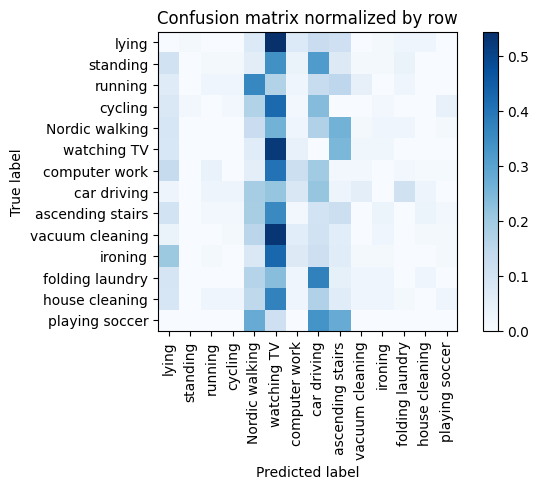

Training Epoch:  30%|███       | 6/20 [00:22<00:52,  3.78s/it]

Overall accuracy: 0.070



eval: 100%|██████████| 31/31 [00:00<00:00, 65.82batch/s, loss=3.11]


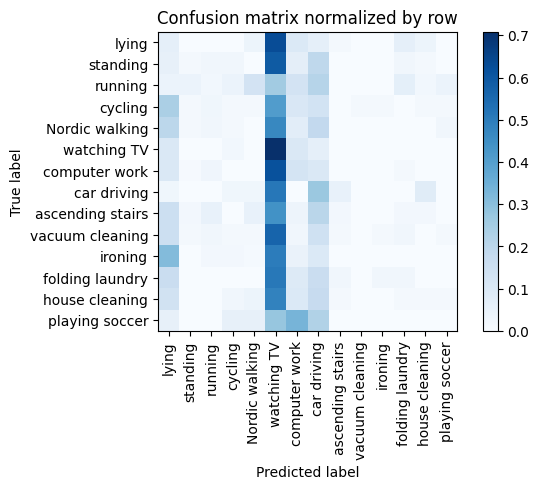

Training Epoch:  35%|███▌      | 7/20 [00:26<00:49,  3.80s/it]

Overall accuracy: 0.073



eval: 100%|██████████| 31/31 [00:00<00:00, 71.26batch/s, loss=3.02]


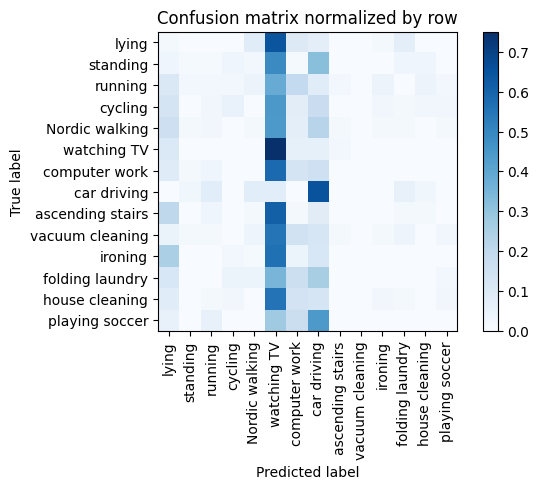

Training Epoch:  40%|████      | 8/20 [00:30<00:44,  3.72s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 31/31 [00:00<00:00, 66.59batch/s, loss=4.28]


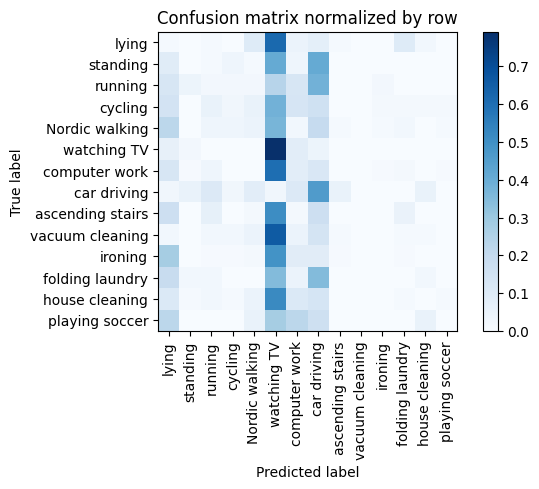

Training Epoch:  45%|████▌     | 9/20 [00:33<00:40,  3.67s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 31/31 [00:00<00:00, 60.96batch/s, loss=3.44]


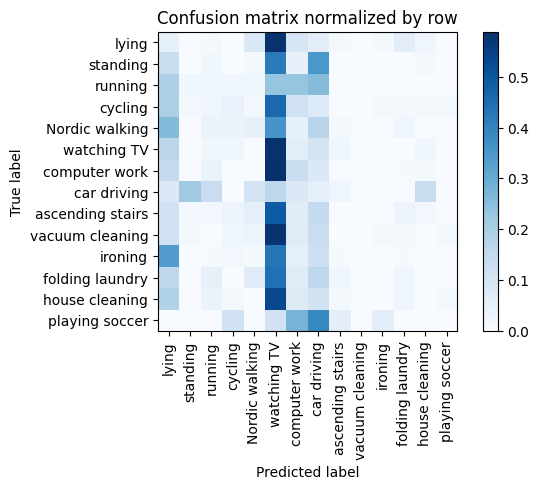

Training Epoch:  50%|█████     | 10/20 [00:37<00:37,  3.72s/it]

Overall accuracy: 0.061



eval: 100%|██████████| 31/31 [00:00<00:00, 67.83batch/s, loss=3.2]


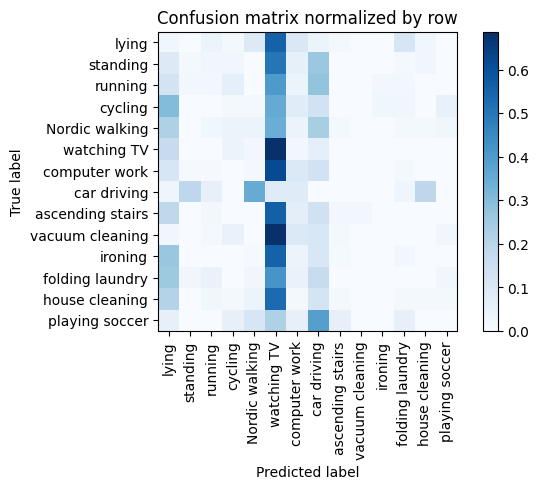

Training Epoch:  55%|█████▌    | 11/20 [00:41<00:33,  3.71s/it]

Overall accuracy: 0.056



eval: 100%|██████████| 31/31 [00:00<00:00, 65.46batch/s, loss=2.79]


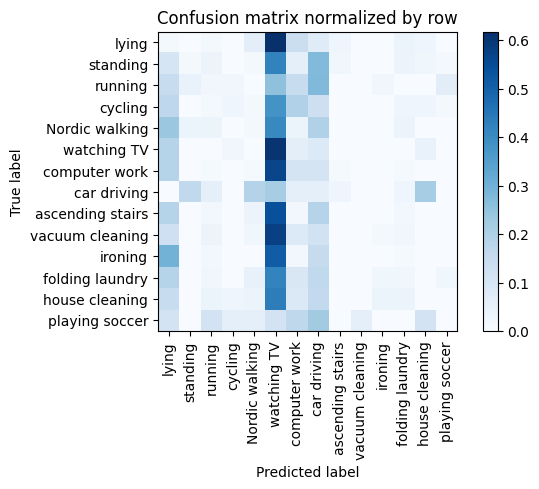

Training Epoch:  60%|██████    | 12/20 [00:44<00:29,  3.69s/it]

Overall accuracy: 0.053



eval: 100%|██████████| 31/31 [00:00<00:00, 54.87batch/s, loss=4.19]


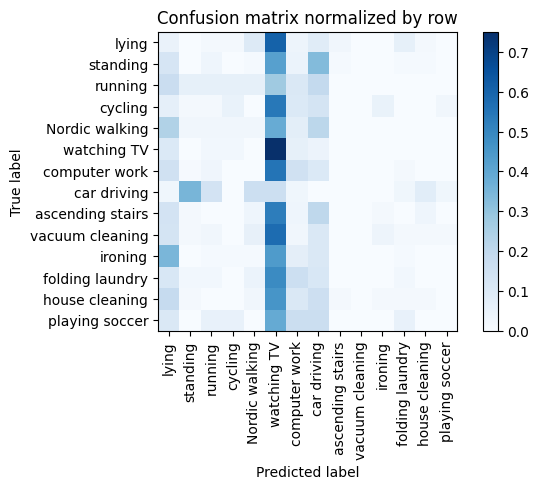

Training Epoch:  65%|██████▌   | 13/20 [00:48<00:26,  3.78s/it]

Overall accuracy: 0.072



eval: 100%|██████████| 31/31 [00:00<00:00, 62.22batch/s, loss=3.32]


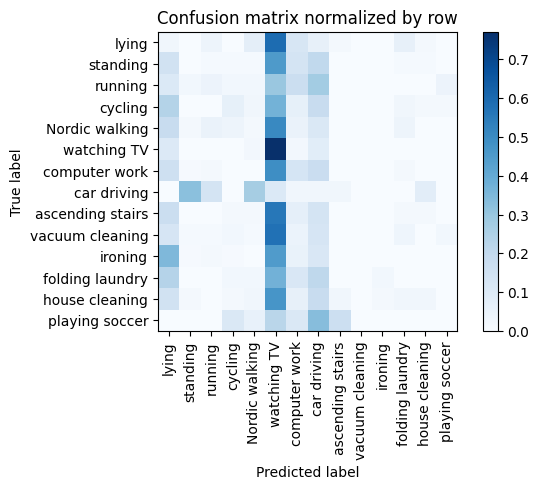

Training Epoch:  70%|███████   | 14/20 [00:52<00:23,  3.87s/it]

Overall accuracy: 0.069



eval: 100%|██████████| 31/31 [00:00<00:00, 69.90batch/s, loss=2.9]


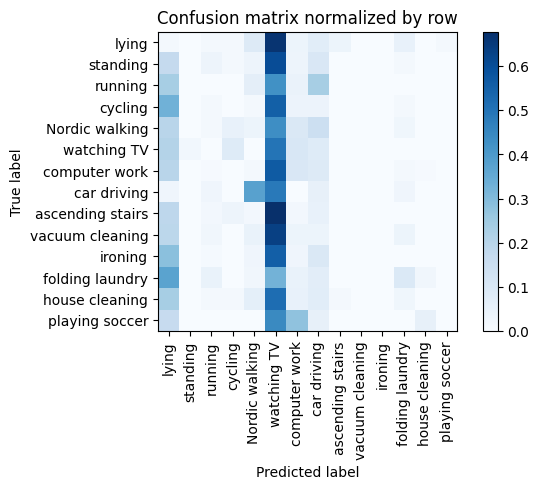

Training Epoch:  75%|███████▌  | 15/20 [00:56<00:19,  3.84s/it]

Overall accuracy: 0.048



eval: 100%|██████████| 31/31 [00:00<00:00, 54.10batch/s, loss=3.01]


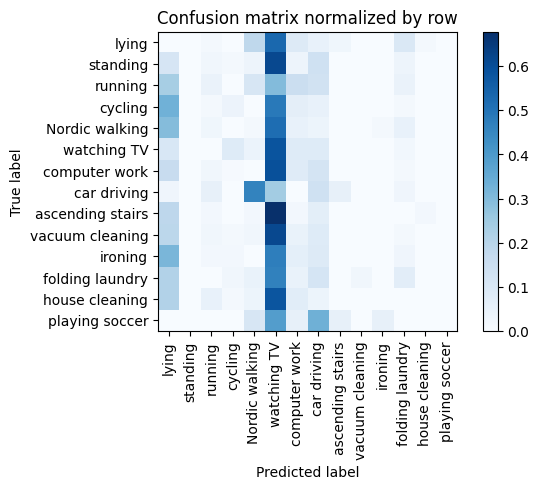

Training Epoch:  80%|████████  | 16/20 [01:00<00:15,  3.89s/it]

Overall accuracy: 0.053



eval: 100%|██████████| 31/31 [00:00<00:00, 58.69batch/s, loss=2.67]


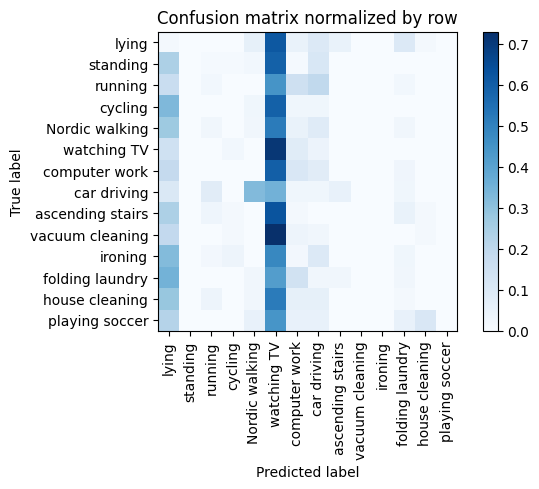

Training Epoch:  85%|████████▌ | 17/20 [01:04<00:11,  3.91s/it]

Overall accuracy: 0.055



eval: 100%|██████████| 31/31 [00:00<00:00, 53.63batch/s, loss=2.98]


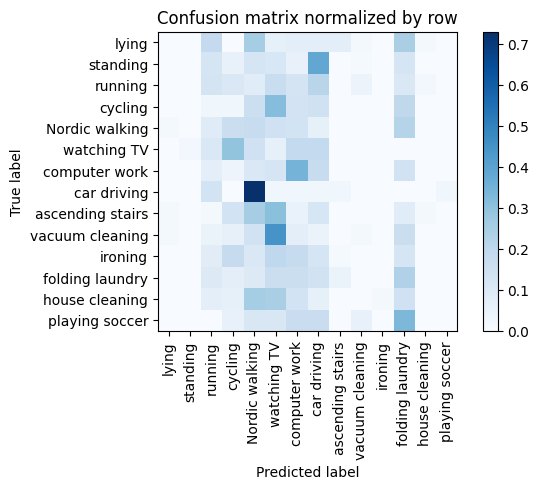

Training Epoch:  90%|█████████ | 18/20 [01:09<00:08,  4.08s/it]

Overall accuracy: 0.085



eval: 100%|██████████| 31/31 [00:00<00:00, 55.55batch/s, loss=3.2]


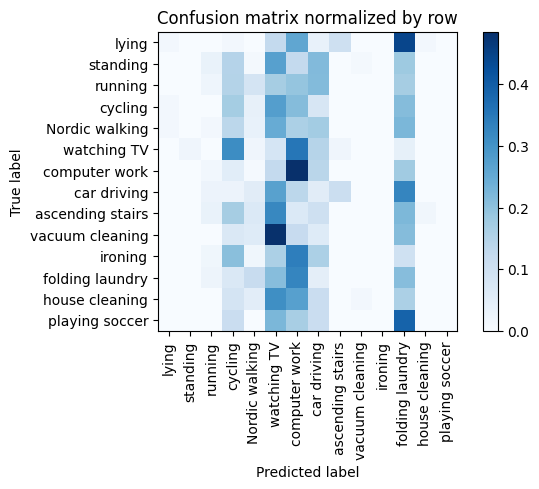

Training Epoch:  95%|█████████▌| 19/20 [01:13<00:04,  4.15s/it]

Overall accuracy: 0.100



eval: 100%|██████████| 31/31 [00:00<00:00, 67.74batch/s, loss=3.04]


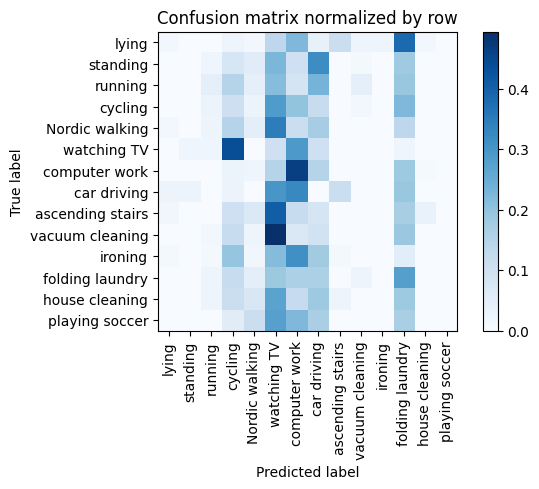

Overall accuracy: 0.096



eval: 100%|██████████| 33/33 [00:00<00:00, 69.43batch/s, loss=1.56]


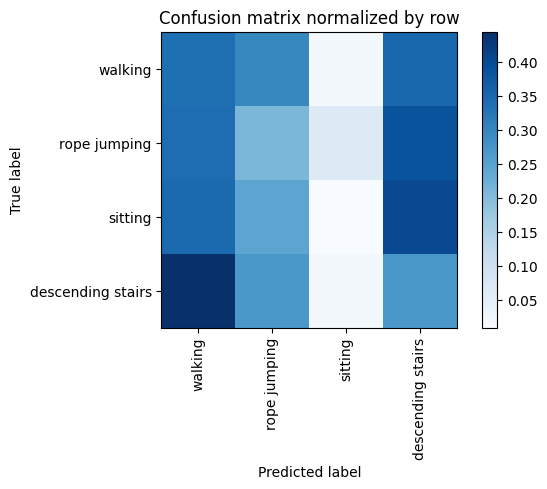

Overall accuracy: 0.209

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.397      0.337      0.365      0.423        442|	 descending stairs: 0.351,	rope jumping: 0.296,	
          sitting       0.158      0.009      0.017      0.320        335|	 descending stairs: 0.400,	walking: 0.346,	rope jumping: 0.245,	
descending stairs       0.129      0.270      0.175      0.170        178|	 walking: 0.444,	rope jumping: 0.270,	
     rope jumping       0.068      0.209      0.102      0.087         91|	 descending stairs: 0.385,	walking: 0.341,	

----------------------------------------------------------------------------------------------------
      avg / total       0.246      0.209      0.198        1.0       1046|	      

{'total_accuracy': 0.20936902485659656, 'precision': 0.1880293677742744, 'recall': 0.20612835660457762, 'f1': 0.16466739127648827}
================ Fold-2 ================
Unseen Classes : ['playing s

eval: 100%|██████████| 29/29 [00:00<00:00, 69.04batch/s, loss=3.34]


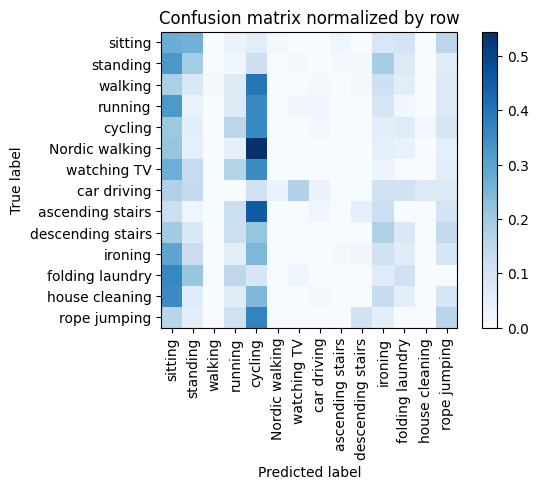

Training Epoch:   5%|▌         | 1/20 [00:03<01:13,  3.89s/it]

Overall accuracy: 0.105



eval: 100%|██████████| 29/29 [00:00<00:00, 62.70batch/s, loss=3.8]


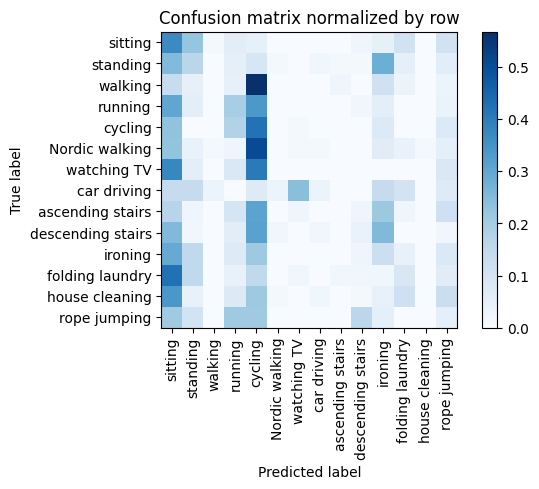

Training Epoch:  10%|█         | 2/20 [00:07<01:07,  3.78s/it]

Overall accuracy: 0.123



eval: 100%|██████████| 29/29 [00:00<00:00, 64.08batch/s, loss=2.21]


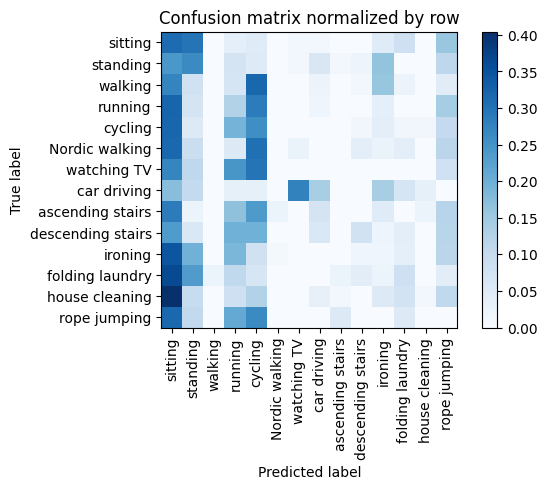

Training Epoch:  15%|█▌        | 3/20 [00:11<01:05,  3.87s/it]

Overall accuracy: 0.103



eval: 100%|██████████| 29/29 [00:00<00:00, 70.79batch/s, loss=2.6]


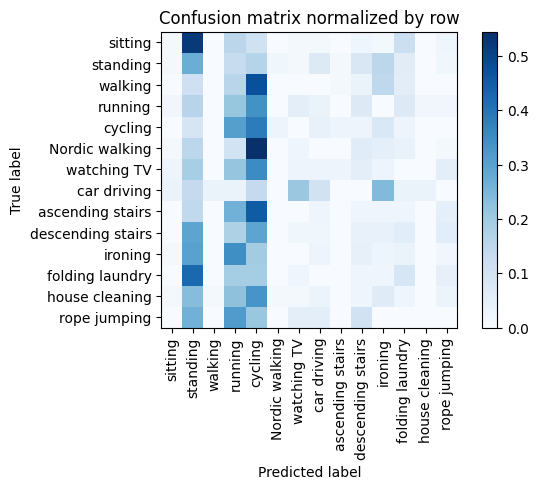

Training Epoch:  20%|██        | 4/20 [00:15<00:59,  3.71s/it]

Overall accuracy: 0.091



eval: 100%|██████████| 29/29 [00:00<00:00, 59.43batch/s, loss=2.98]


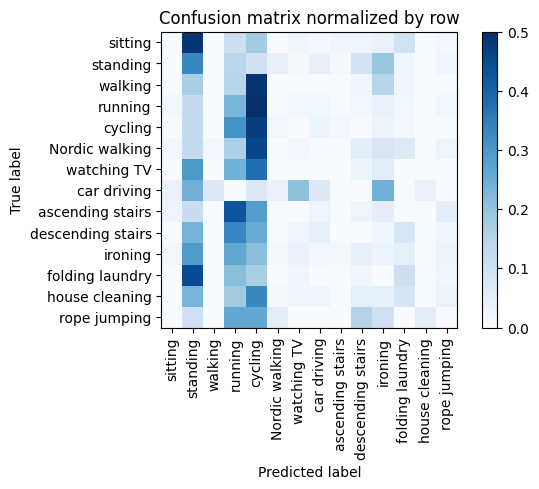

Training Epoch:  25%|██▌       | 5/20 [00:18<00:56,  3.78s/it]

Overall accuracy: 0.102



eval: 100%|██████████| 29/29 [00:00<00:00, 72.76batch/s, loss=3.02]


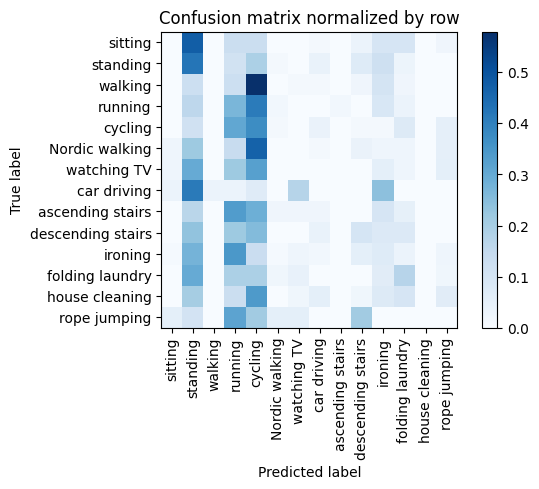

Training Epoch:  30%|███       | 6/20 [00:22<00:51,  3.67s/it]

Overall accuracy: 0.117



eval: 100%|██████████| 29/29 [00:00<00:00, 70.86batch/s, loss=3.25]


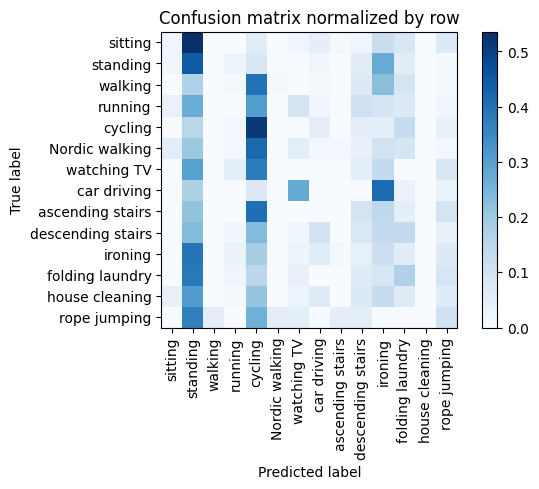

Training Epoch:  35%|███▌      | 7/20 [00:25<00:47,  3.62s/it]

Overall accuracy: 0.123



eval: 100%|██████████| 29/29 [00:00<00:00, 59.59batch/s, loss=3.1]


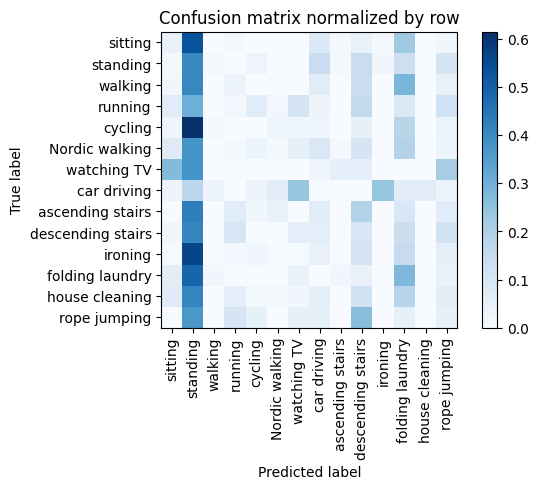

Training Epoch:  40%|████      | 8/20 [00:29<00:43,  3.63s/it]

Overall accuracy: 0.071



eval: 100%|██████████| 29/29 [00:00<00:00, 61.70batch/s, loss=2.76]


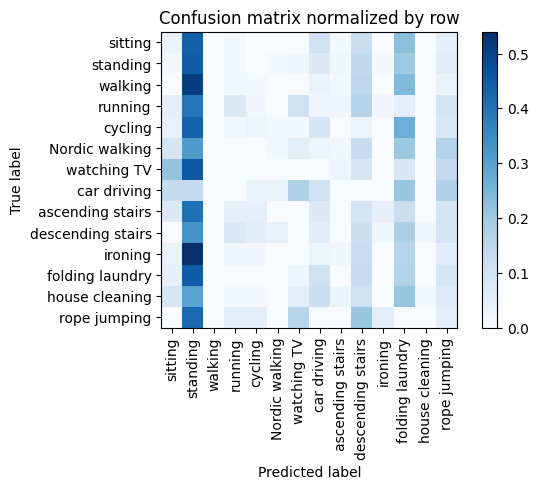

Training Epoch:  45%|████▌     | 9/20 [00:33<00:41,  3.77s/it]

Overall accuracy: 0.080



eval: 100%|██████████| 29/29 [00:00<00:00, 65.68batch/s, loss=3.6]


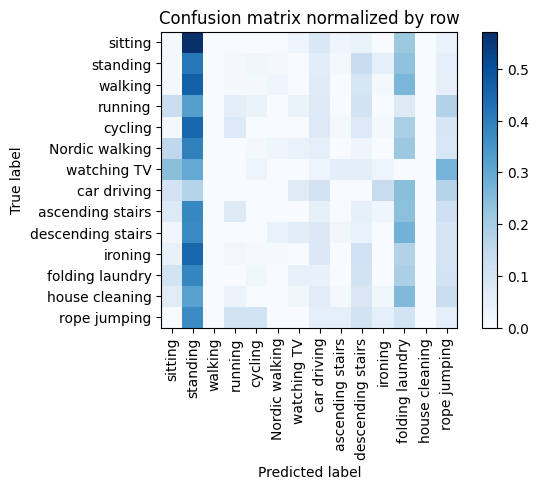

Training Epoch:  50%|█████     | 10/20 [00:37<00:37,  3.74s/it]

Overall accuracy: 0.068



eval: 100%|██████████| 29/29 [00:00<00:00, 68.08batch/s, loss=3.12]


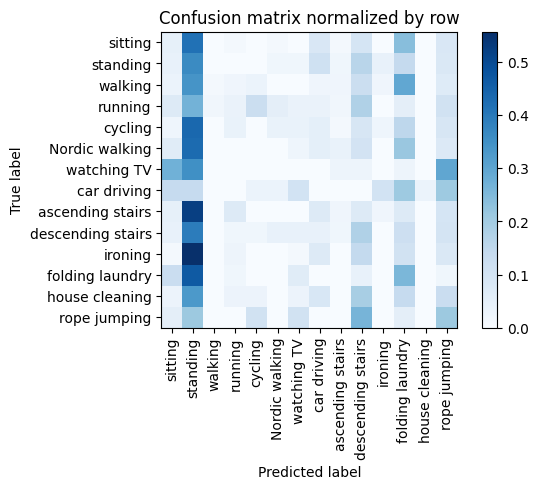

Training Epoch:  55%|█████▌    | 11/20 [00:40<00:32,  3.66s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 29/29 [00:00<00:00, 63.83batch/s, loss=3.14]


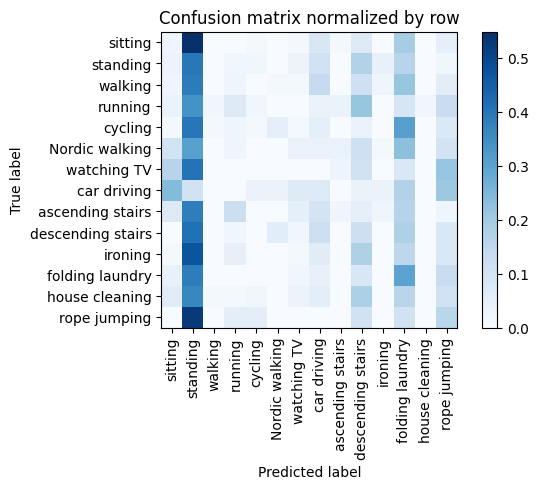

Training Epoch:  60%|██████    | 12/20 [00:44<00:29,  3.66s/it]

Overall accuracy: 0.079



eval: 100%|██████████| 29/29 [00:00<00:00, 54.64batch/s, loss=3.34]


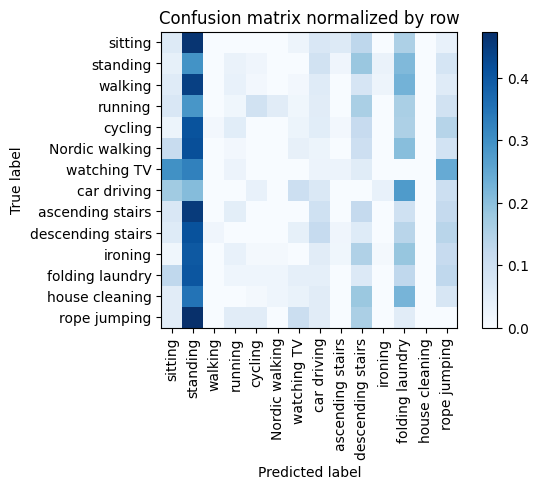

Training Epoch:  65%|██████▌   | 13/20 [00:47<00:25,  3.62s/it]

Overall accuracy: 0.051



eval: 100%|██████████| 29/29 [00:00<00:00, 64.15batch/s, loss=2.1]


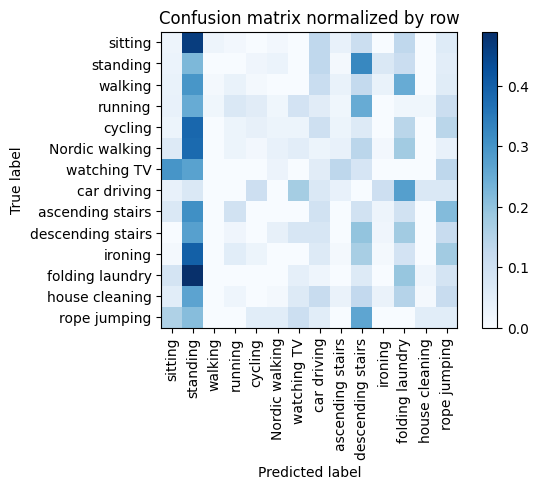

Training Epoch:  70%|███████   | 14/20 [00:51<00:22,  3.71s/it]

Overall accuracy: 0.064



eval: 100%|██████████| 29/29 [00:00<00:00, 68.15batch/s, loss=2.62]


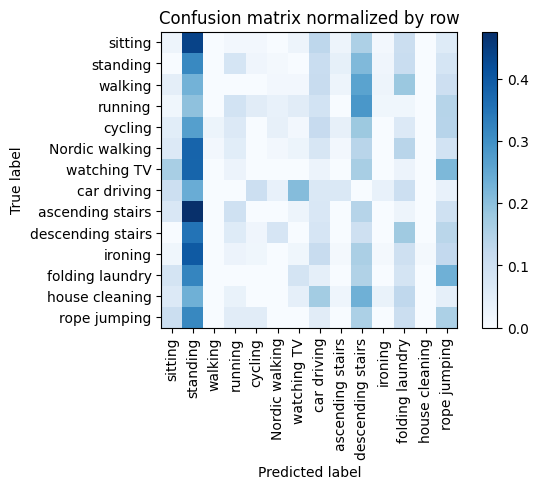

Training Epoch:  75%|███████▌  | 15/20 [00:55<00:18,  3.67s/it]

Overall accuracy: 0.059



eval: 100%|██████████| 29/29 [00:00<00:00, 54.91batch/s, loss=3.06]


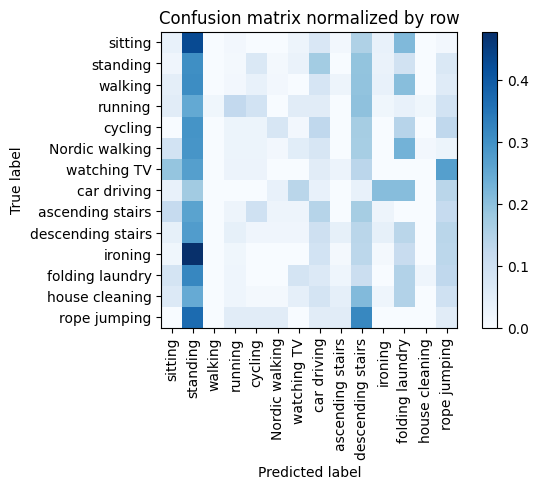

Training Epoch:  80%|████████  | 16/20 [00:59<00:14,  3.72s/it]

Overall accuracy: 0.066



eval: 100%|██████████| 29/29 [00:00<00:00, 65.86batch/s, loss=2.77]


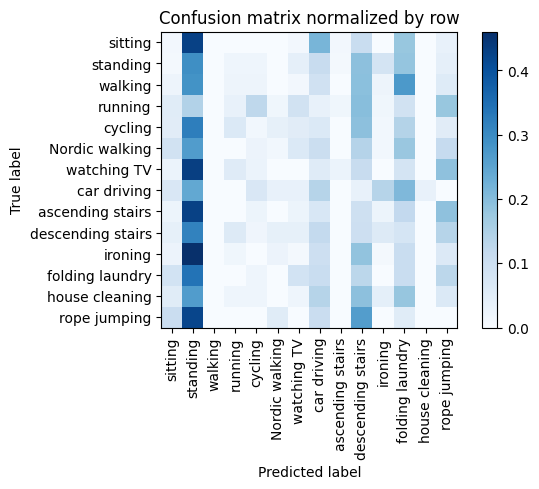

Training Epoch:  85%|████████▌ | 17/20 [01:02<00:10,  3.65s/it]

Overall accuracy: 0.053



eval: 100%|██████████| 29/29 [00:00<00:00, 69.61batch/s, loss=3.12]


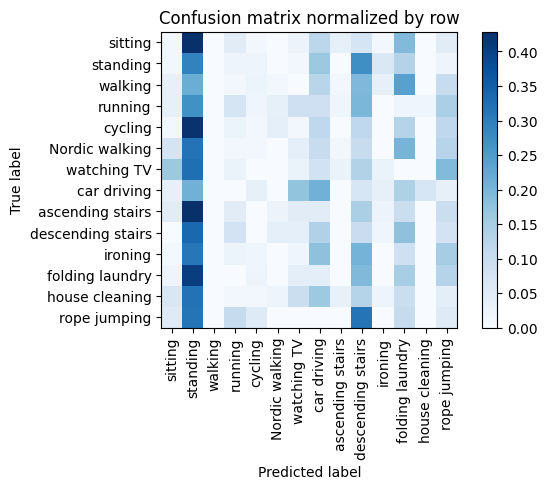

Training Epoch:  90%|█████████ | 18/20 [01:06<00:07,  3.68s/it]

Overall accuracy: 0.060



eval: 100%|██████████| 29/29 [00:00<00:00, 68.40batch/s, loss=2.43]


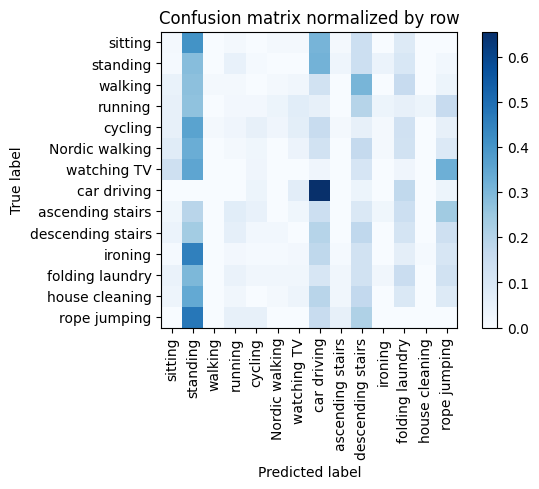

Training Epoch:  95%|█████████▌| 19/20 [01:10<00:03,  3.64s/it]

Overall accuracy: 0.076



eval: 100%|██████████| 29/29 [00:00<00:00, 64.58batch/s, loss=3.9]


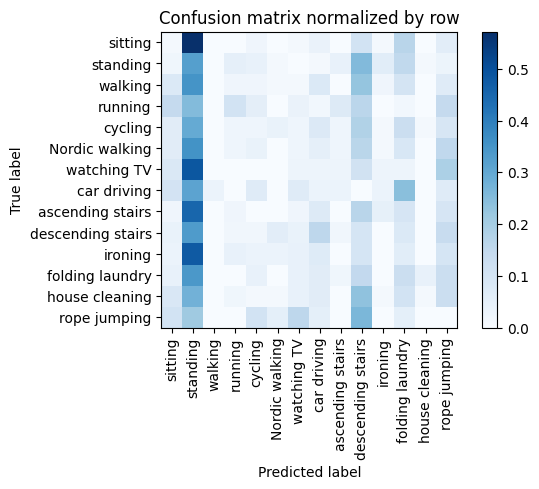

Overall accuracy: 0.060



eval: 100%|██████████| 43/43 [00:00<00:00, 77.89batch/s, loss=2.71]


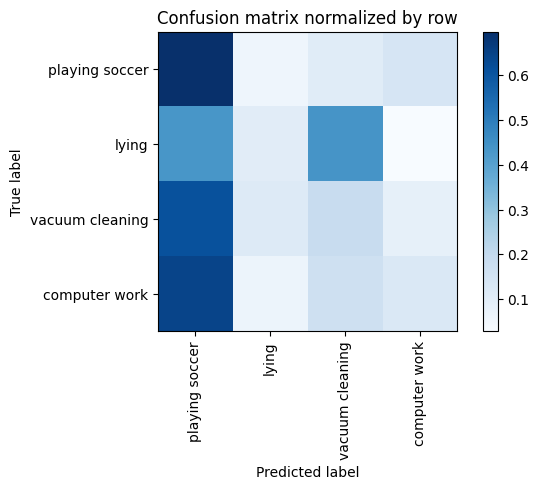

Overall accuracy: 0.170

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.587      0.123      0.204      0.426        575|	 playing soccer: 0.643,	vacuum cleaning: 0.169,	
          lying       0.308      0.102      0.153      0.262        354|	 vacuum cleaning: 0.438,	playing soccer: 0.432,	
vacuum cleaning       0.192      0.186      0.189      0.248        334|	 playing soccer: 0.614,	lying: 0.117,	
 playing soccer       0.076      0.698      0.137      0.064         86|	 computer work: 0.140,	vacuum cleaning: 0.105,	

----------------------------------------------------------------------------------------------------
    avg / total       0.383      0.170      0.183 0.9999999999999999       1349|	      

{'total_accuracy': 0.1697553743513714, 'precision': 0.29064044089310503, 'recall': 0.27711908431085597, 'f1': 0.17073142089959464}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nor

eval: 100%|██████████| 33/33 [00:00<00:00, 59.83batch/s, loss=2.19]


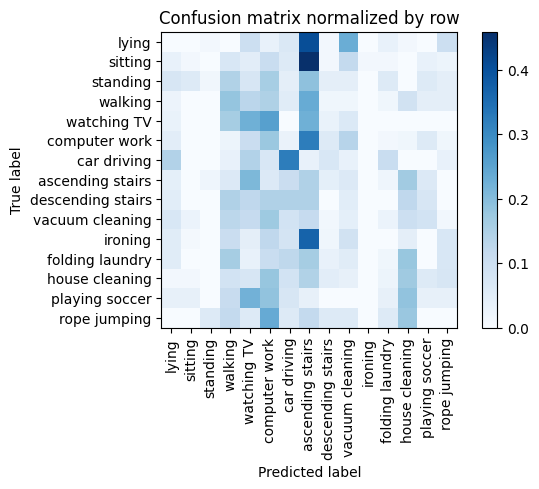

Training Epoch:   5%|▌         | 1/20 [00:04<01:19,  4.19s/it]

Overall accuracy: 0.091



eval: 100%|██████████| 33/33 [00:00<00:00, 70.72batch/s, loss=2.06]


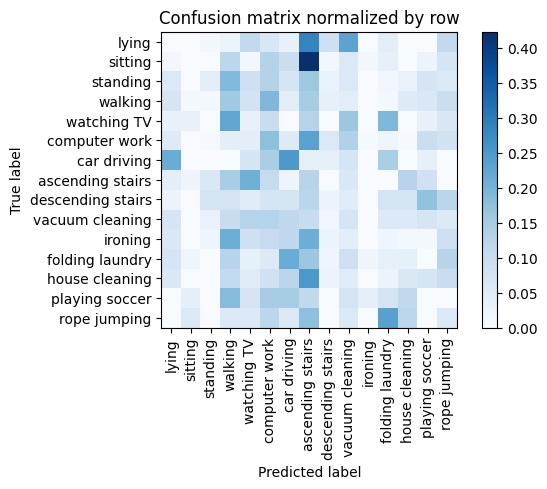

Training Epoch:  10%|█         | 2/20 [00:08<01:12,  4.03s/it]

Overall accuracy: 0.076



eval: 100%|██████████| 33/33 [00:00<00:00, 68.32batch/s, loss=2.24]


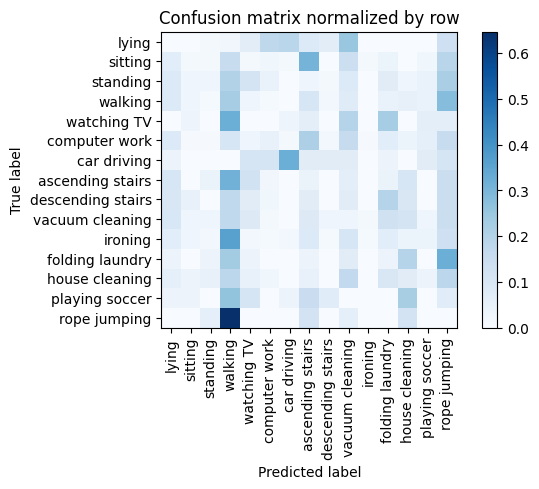

Training Epoch:  15%|█▌        | 3/20 [00:12<01:07,  3.99s/it]

Overall accuracy: 0.056



eval: 100%|██████████| 33/33 [00:00<00:00, 68.03batch/s, loss=2.79]


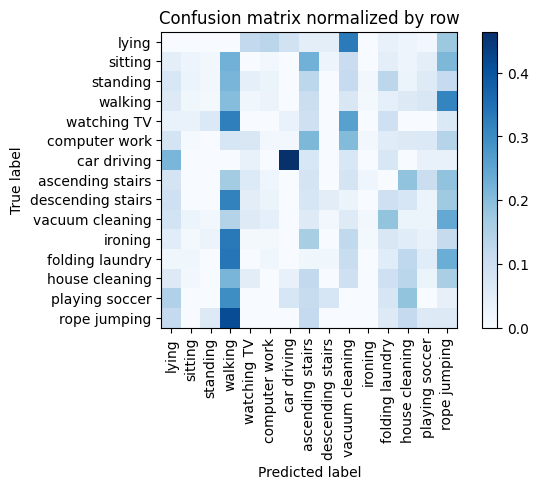

Training Epoch:  20%|██        | 4/20 [00:16<01:04,  4.04s/it]

Overall accuracy: 0.064



eval: 100%|██████████| 33/33 [00:00<00:00, 68.18batch/s, loss=2.59]


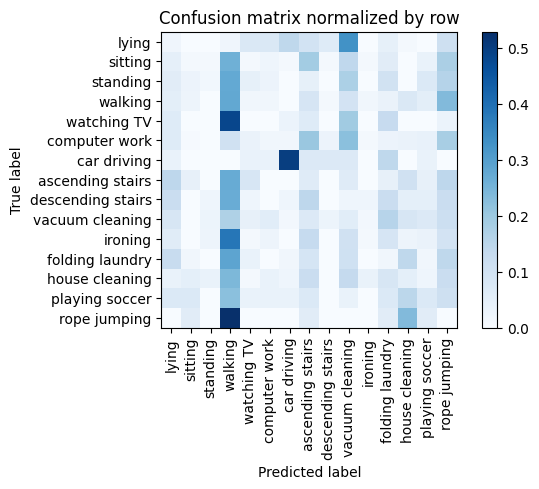

Training Epoch:  25%|██▌       | 5/20 [00:20<01:00,  4.06s/it]

Overall accuracy: 0.065



eval: 100%|██████████| 33/33 [00:00<00:00, 68.51batch/s, loss=2.19]


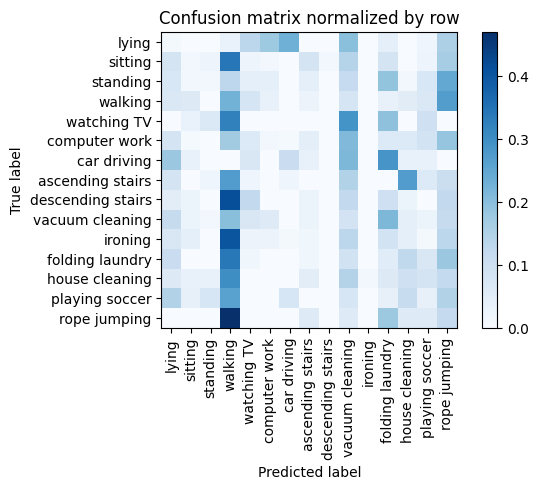

Training Epoch:  30%|███       | 6/20 [00:24<00:55,  4.00s/it]

Overall accuracy: 0.052



eval: 100%|██████████| 33/33 [00:00<00:00, 68.75batch/s, loss=2.32]


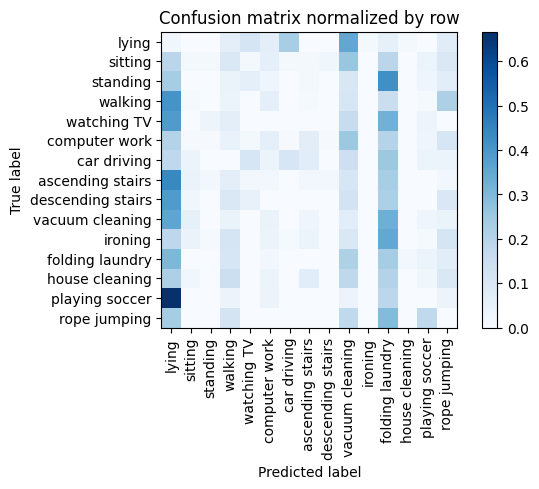

Training Epoch:  35%|███▌      | 7/20 [00:28<00:51,  3.96s/it]

Overall accuracy: 0.037



eval: 100%|██████████| 33/33 [00:00<00:00, 63.63batch/s, loss=2.35]


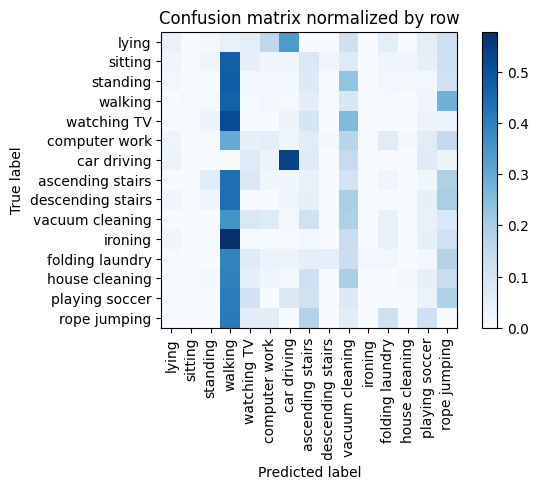

Training Epoch:  40%|████      | 8/20 [00:32<00:47,  3.99s/it]

Overall accuracy: 0.097



eval: 100%|██████████| 33/33 [00:00<00:00, 69.73batch/s, loss=2.49]


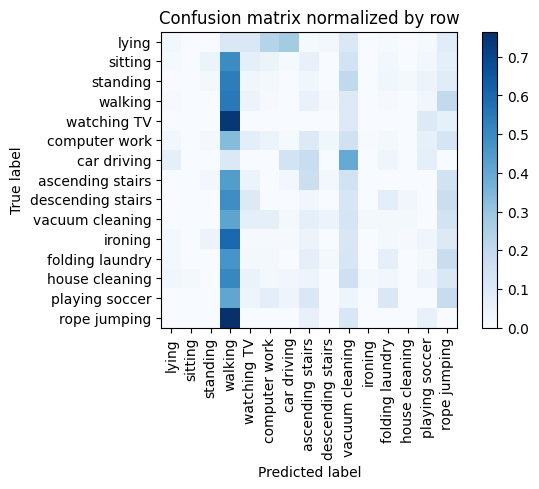

Training Epoch:  45%|████▌     | 9/20 [00:36<00:43,  4.00s/it]

Overall accuracy: 0.094



eval: 100%|██████████| 33/33 [00:00<00:00, 66.27batch/s, loss=2.27]


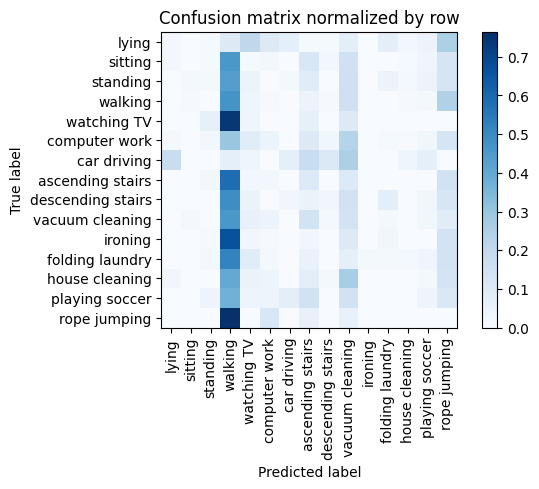

Training Epoch:  50%|█████     | 10/20 [00:40<00:40,  4.00s/it]

Overall accuracy: 0.081



eval: 100%|██████████| 33/33 [00:00<00:00, 67.07batch/s, loss=2.65]


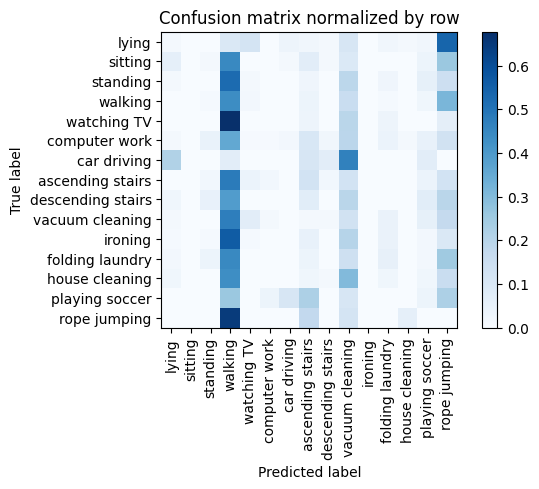

Training Epoch:  55%|█████▌    | 11/20 [00:44<00:36,  4.03s/it]

Overall accuracy: 0.068



eval: 100%|██████████| 33/33 [00:00<00:00, 70.35batch/s, loss=2.16]


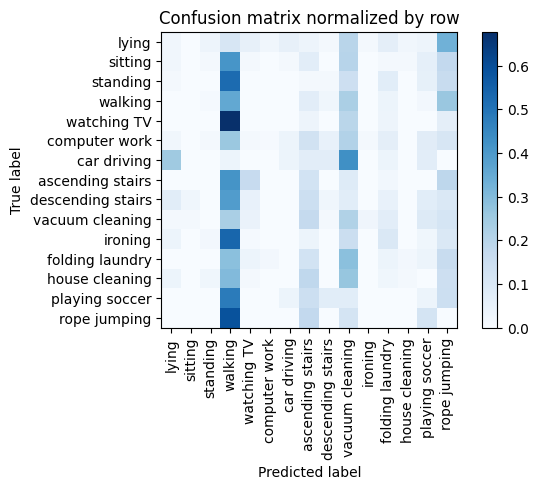

Training Epoch:  60%|██████    | 12/20 [00:48<00:31,  4.00s/it]

Overall accuracy: 0.068



eval: 100%|██████████| 33/33 [00:00<00:00, 71.74batch/s, loss=2.1]


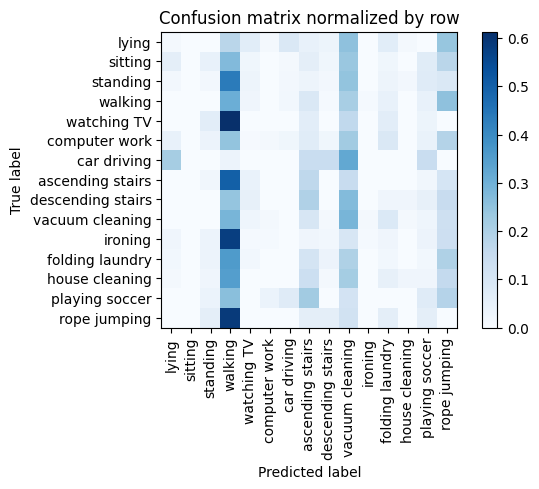

Training Epoch:  65%|██████▌   | 13/20 [00:52<00:27,  3.96s/it]

Overall accuracy: 0.070



eval: 100%|██████████| 33/33 [00:00<00:00, 66.66batch/s, loss=3.47]


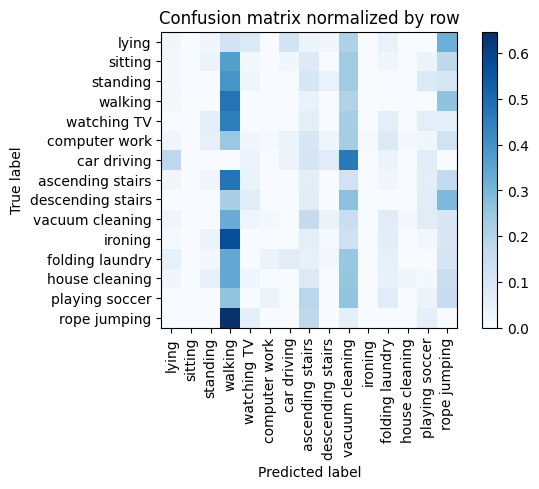

Training Epoch:  70%|███████   | 14/20 [00:56<00:23,  4.00s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 33/33 [00:00<00:00, 63.34batch/s, loss=2.98]


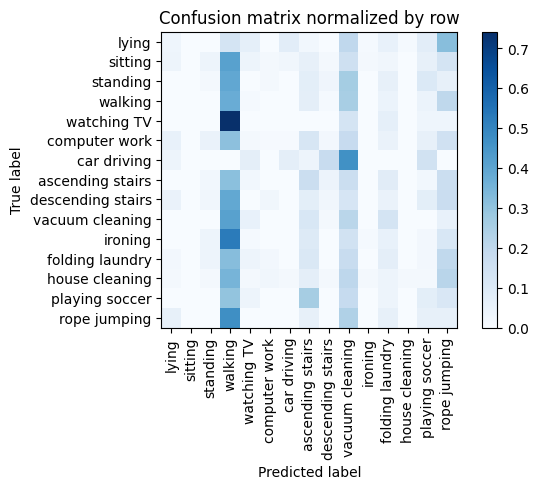

Training Epoch:  75%|███████▌  | 15/20 [01:00<00:20,  4.06s/it]

Overall accuracy: 0.079



eval: 100%|██████████| 33/33 [00:00<00:00, 69.90batch/s, loss=2.45]


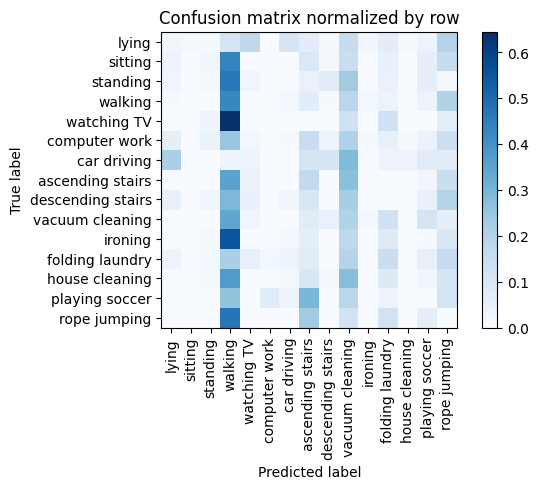

Training Epoch:  80%|████████  | 16/20 [01:04<00:16,  4.08s/it]

Overall accuracy: 0.078



eval: 100%|██████████| 33/33 [00:00<00:00, 61.28batch/s, loss=2.69]


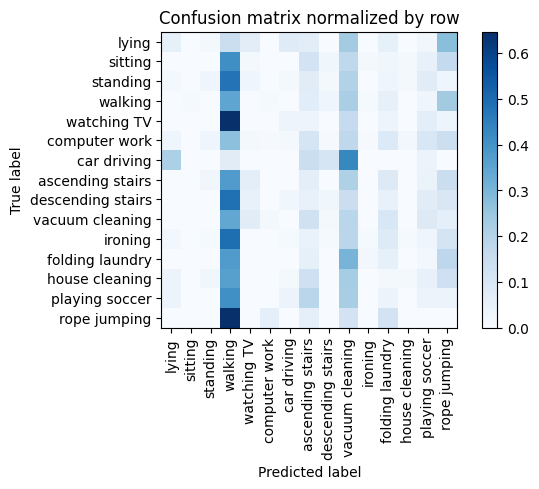

Training Epoch:  85%|████████▌ | 17/20 [01:08<00:12,  4.11s/it]

Overall accuracy: 0.068



eval: 100%|██████████| 33/33 [00:00<00:00, 56.24batch/s, loss=2.48]


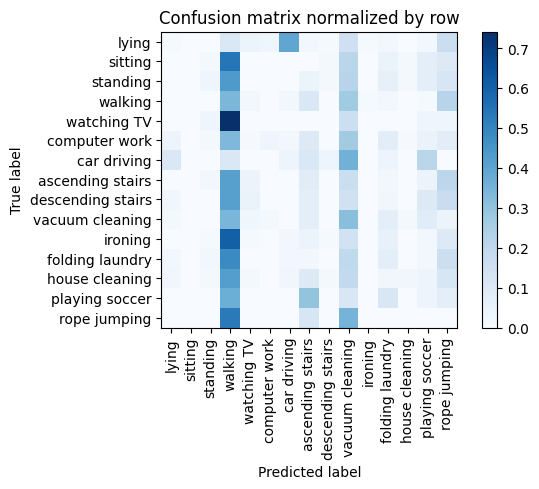

Training Epoch:  90%|█████████ | 18/20 [01:12<00:08,  4.14s/it]

Overall accuracy: 0.077



eval: 100%|██████████| 33/33 [00:00<00:00, 68.18batch/s, loss=2.61]


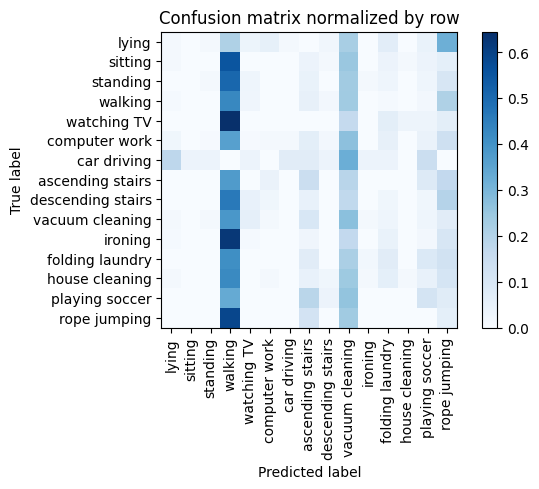

Training Epoch:  95%|█████████▌| 19/20 [01:16<00:04,  4.14s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 33/33 [00:00<00:00, 66.67batch/s, loss=2.79]


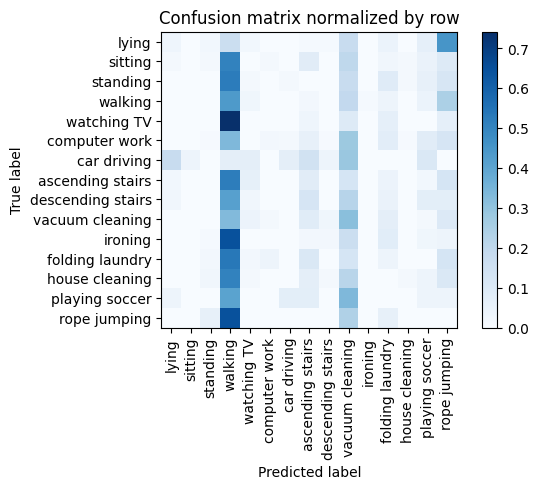

Overall accuracy: 0.084



eval: 100%|██████████| 26/26 [00:00<00:00, 76.92batch/s, loss=4.86]


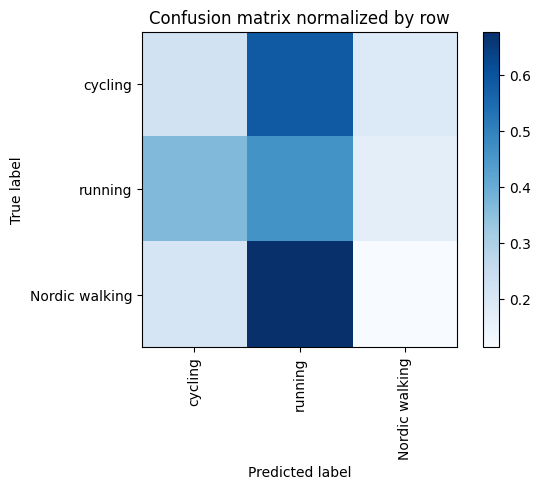

Overall accuracy: 0.228

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.312      0.114      0.167      0.422        350|	 running: 0.677,	cycling: 0.209,	
       cycling       0.332      0.223      0.267      0.367        305|	 running: 0.587,	Nordic walking: 0.190,	
       running       0.163      0.463      0.241      0.211        175|	 cycling: 0.366,	Nordic walking: 0.171,	

----------------------------------------------------------------------------------------------------
   avg / total       0.288      0.228      0.219        1.0        830|	      

{'total_accuracy': 0.22771084337349398, 'precision': 0.26906172809213, 'recall': 0.2666978922716628, 'f1': 0.2250340373248323}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 34/34 [00:00<00:00, 53.53batch/s, loss=2.43]


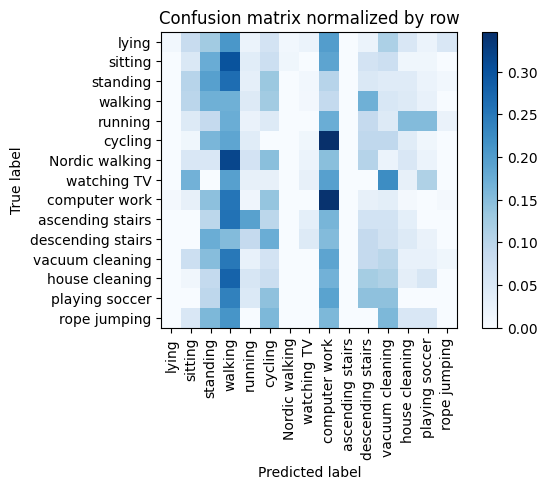

Training Epoch:   5%|▌         | 1/20 [00:04<01:29,  4.73s/it]

Overall accuracy: 0.103



eval: 100%|██████████| 34/34 [00:00<00:00, 69.80batch/s, loss=3.64]


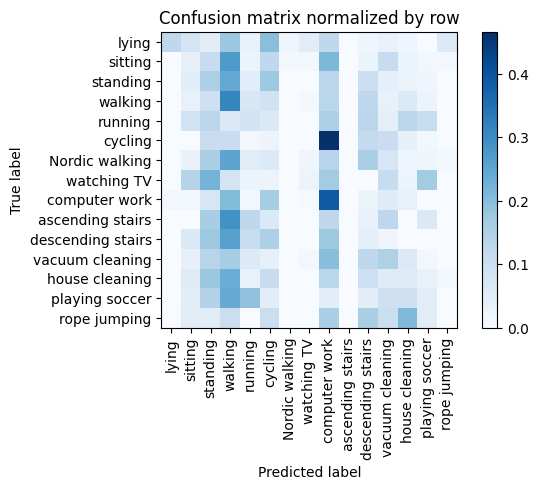

Training Epoch:  10%|█         | 2/20 [00:09<01:27,  4.85s/it]

Overall accuracy: 0.139



eval: 100%|██████████| 34/34 [00:00<00:00, 72.04batch/s, loss=2.7]


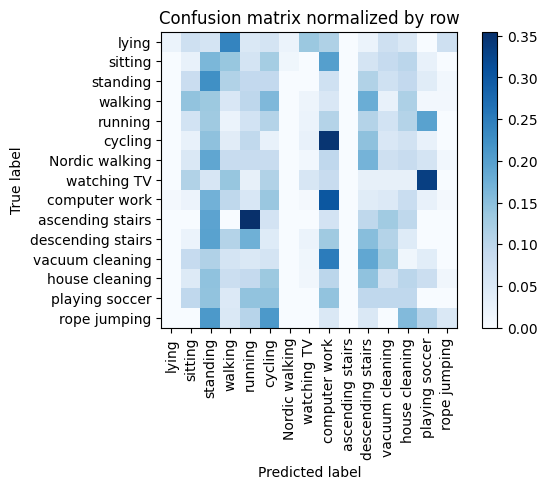

Training Epoch:  15%|█▌        | 3/20 [00:13<01:16,  4.51s/it]

Overall accuracy: 0.103



eval: 100%|██████████| 34/34 [00:00<00:00, 68.97batch/s, loss=2.78]


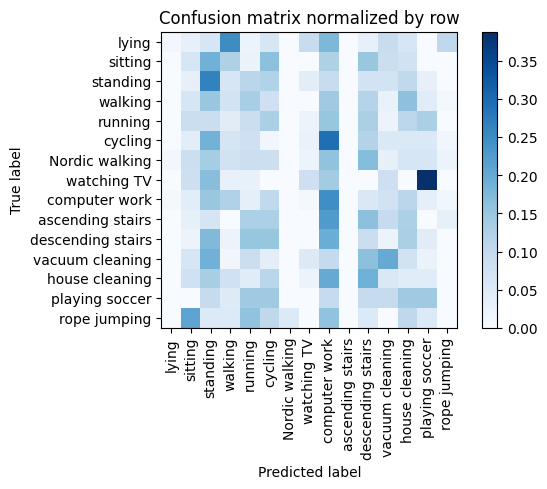

Training Epoch:  20%|██        | 4/20 [00:18<01:10,  4.41s/it]

Overall accuracy: 0.104



eval: 100%|██████████| 34/34 [00:00<00:00, 67.66batch/s, loss=2.49]


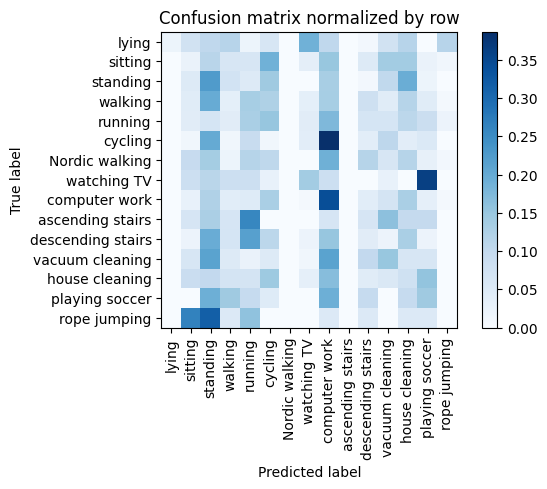

Training Epoch:  25%|██▌       | 5/20 [00:22<01:05,  4.40s/it]

Overall accuracy: 0.108



eval: 100%|██████████| 34/34 [00:00<00:00, 67.06batch/s, loss=2.67]


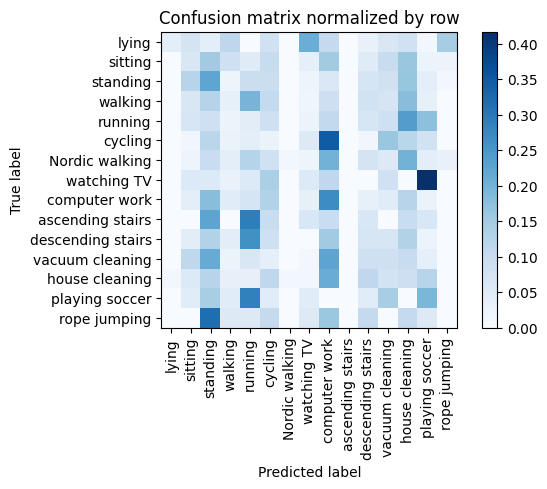

Training Epoch:  30%|███       | 6/20 [00:26<01:01,  4.37s/it]

Overall accuracy: 0.096



eval: 100%|██████████| 34/34 [00:00<00:00, 60.50batch/s, loss=1.98]


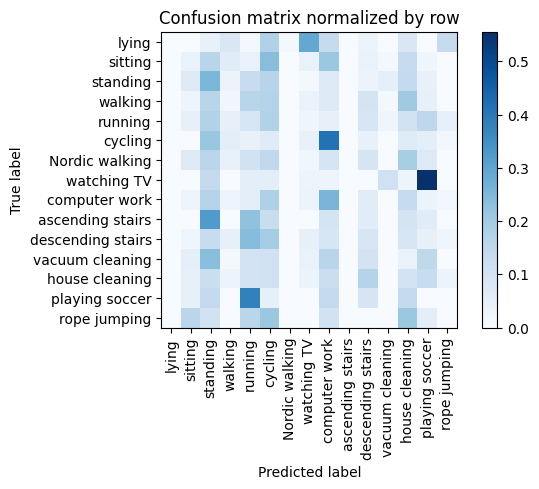

Training Epoch:  35%|███▌      | 7/20 [00:31<00:56,  4.36s/it]

Overall accuracy: 0.085



eval: 100%|██████████| 34/34 [00:00<00:00, 68.41batch/s, loss=2.63]


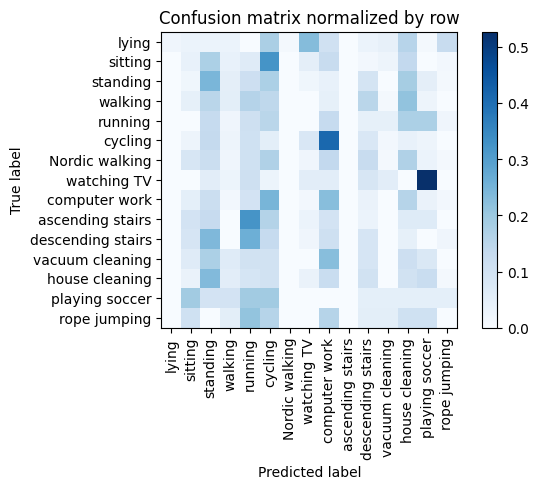

Training Epoch:  40%|████      | 8/20 [00:35<00:51,  4.28s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 34/34 [00:00<00:00, 72.50batch/s, loss=2.55]


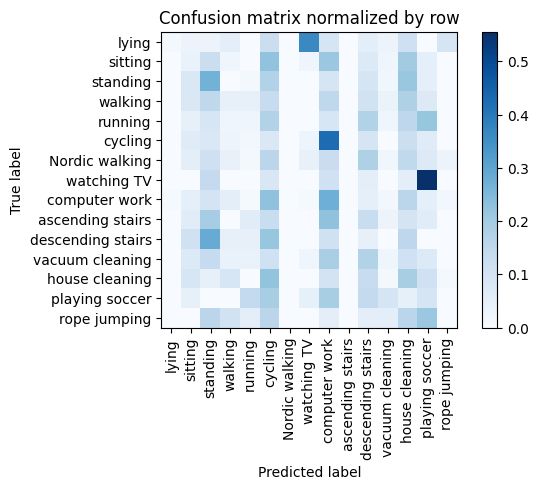

Training Epoch:  45%|████▌     | 9/20 [00:39<00:46,  4.26s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 34/34 [00:00<00:00, 65.07batch/s, loss=2.59]


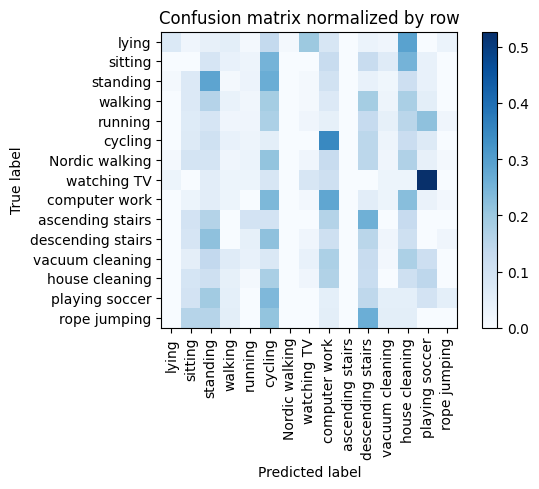

Training Epoch:  50%|█████     | 10/20 [00:43<00:43,  4.31s/it]

Overall accuracy: 0.101



eval: 100%|██████████| 34/34 [00:00<00:00, 66.00batch/s, loss=2.76]


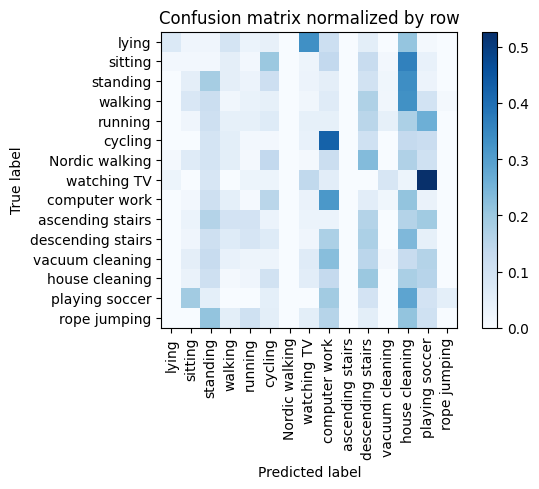

Training Epoch:  55%|█████▌    | 11/20 [00:48<00:38,  4.32s/it]

Overall accuracy: 0.102



eval: 100%|██████████| 34/34 [00:00<00:00, 57.19batch/s, loss=2.37]


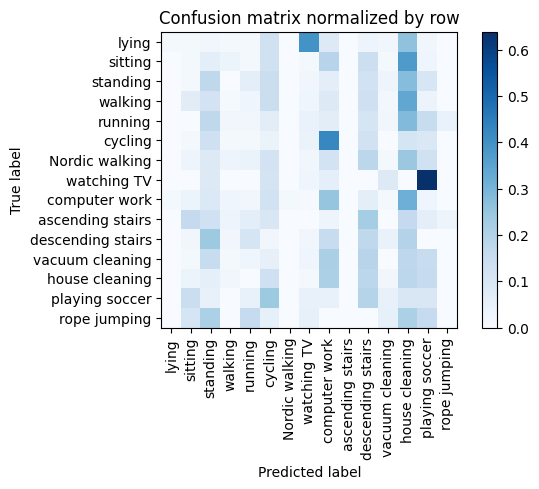

Training Epoch:  60%|██████    | 12/20 [00:52<00:34,  4.35s/it]

Overall accuracy: 0.082



eval: 100%|██████████| 34/34 [00:00<00:00, 68.69batch/s, loss=2.91]


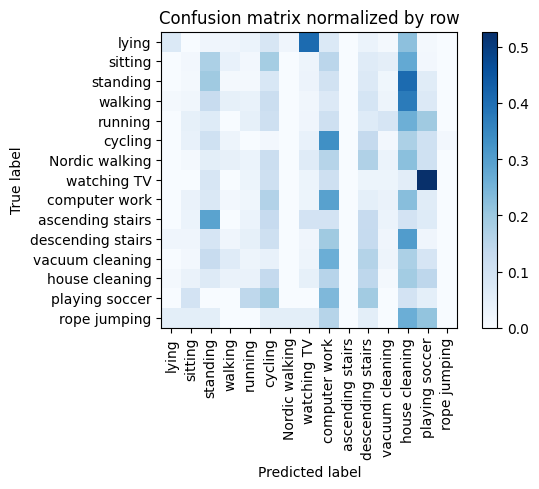

Training Epoch:  65%|██████▌   | 13/20 [00:56<00:30,  4.33s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 34/34 [00:00<00:00, 64.64batch/s, loss=2.64]


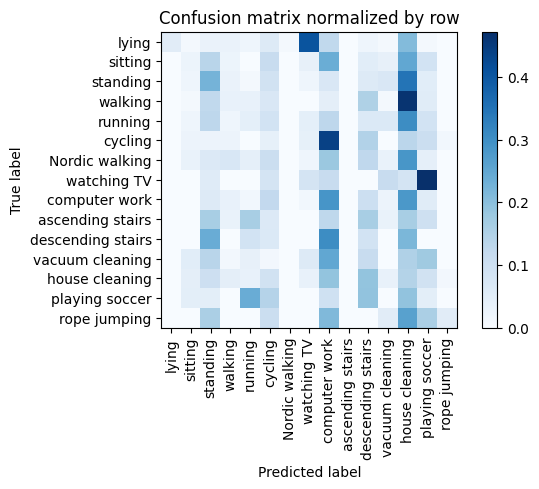

Training Epoch:  70%|███████   | 14/20 [01:01<00:25,  4.28s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 34/34 [00:00<00:00, 68.61batch/s, loss=3.47]


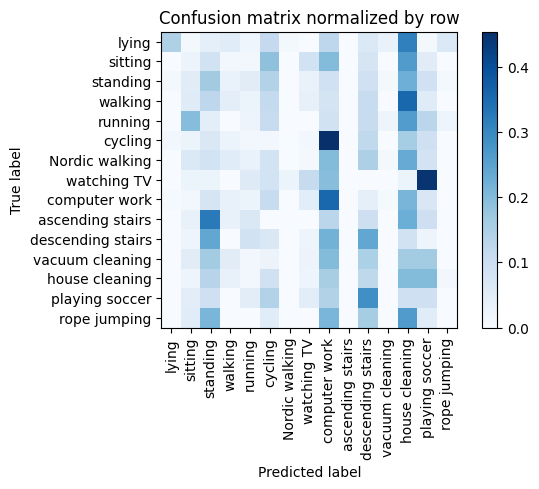

Training Epoch:  75%|███████▌  | 15/20 [01:05<00:21,  4.26s/it]

Overall accuracy: 0.118



eval: 100%|██████████| 34/34 [00:00<00:00, 67.59batch/s, loss=2.21]


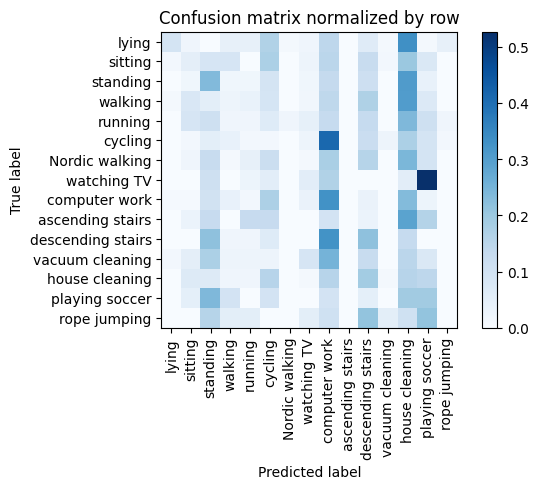

Training Epoch:  80%|████████  | 16/20 [01:09<00:16,  4.24s/it]

Overall accuracy: 0.111



eval: 100%|██████████| 34/34 [00:00<00:00, 68.53batch/s, loss=2.35]


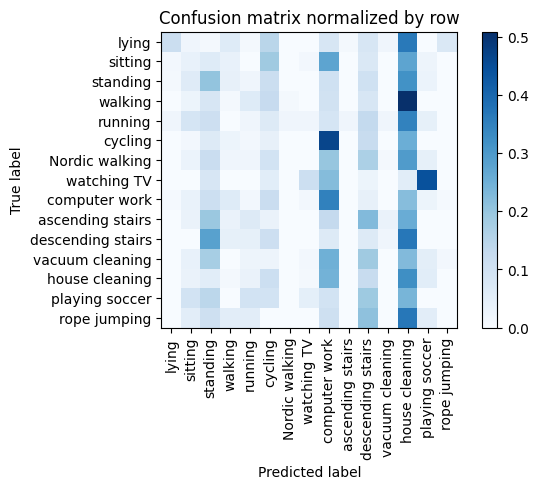

Training Epoch:  85%|████████▌ | 17/20 [01:13<00:12,  4.23s/it]

Overall accuracy: 0.118



eval: 100%|██████████| 34/34 [00:00<00:00, 60.76batch/s, loss=2.64]


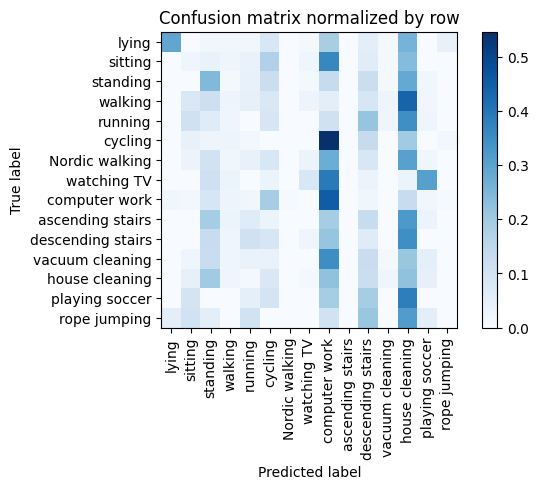

Training Epoch:  90%|█████████ | 18/20 [01:17<00:08,  4.24s/it]

Overall accuracy: 0.140



eval: 100%|██████████| 34/34 [00:00<00:00, 69.13batch/s, loss=2.86]


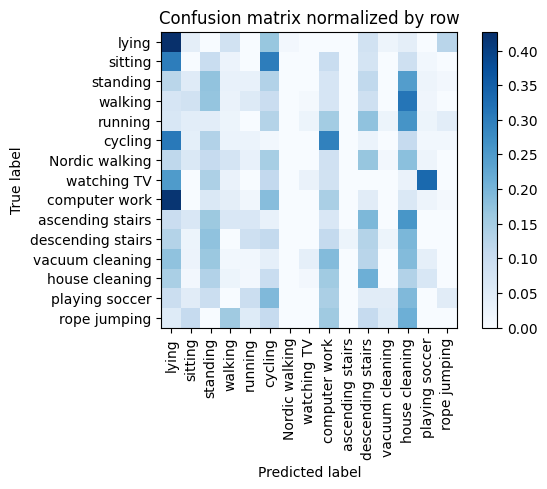

Training Epoch:  95%|█████████▌| 19/20 [01:22<00:04,  4.30s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 34/34 [00:00<00:00, 69.25batch/s, loss=2.71]


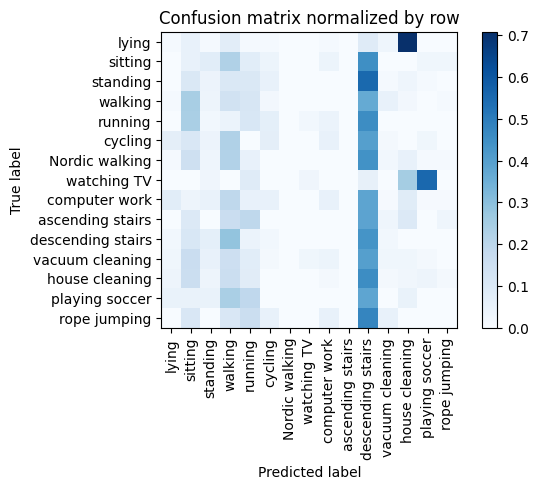

Overall accuracy: 0.063



eval: 100%|██████████| 23/23 [00:00<00:00, 71.86batch/s, loss=4.31]


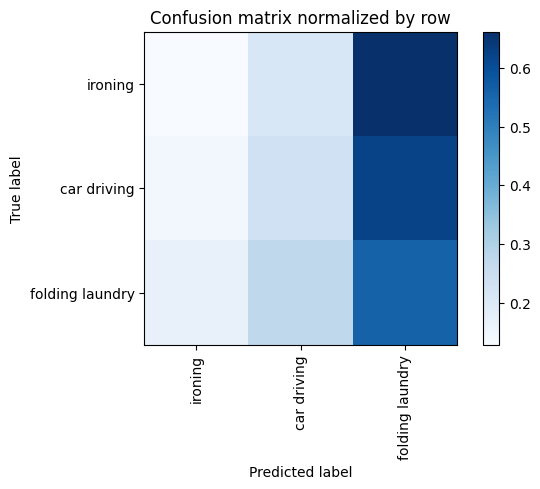

Overall accuracy: 0.248

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.569      0.128      0.209      0.621        453|	 folding laundry: 0.662,	car driving: 0.210,	
folding laundry       0.217      0.559      0.312      0.245        179|	 car driving: 0.274,	ironing: 0.168,	
    car driving       0.138      0.235      0.174      0.134         98|	 folding laundry: 0.622,	ironing: 0.143,	

----------------------------------------------------------------------------------------------------
    avg / total       0.425      0.248      0.230        1.0        730|	      

{'total_accuracy': 0.24794520547945206, 'precision': 0.30775724719163605, 'recall': 0.3071294718388052, 'f1': 0.23169797155646213}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.218737
precision         0.254516
recall            0.255658
f1                0.200883
dtype: float64

In [11]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict ['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model1(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size,attr_size=attr_size, max_len=seq_len)
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=True)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=True, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    